In [3]:
import matplotlib.pyplot as plt
import numpy as np

from aart_func import *
from params import * # The file params.py contains all the relevant parameters for the simulations
from astropy import units as u
import kgeo
import image_tools as tls
import subprocess
import scipy.interpolate
import final_paper_params as fpp
from final_paper_params import (
    bp_fiducial230,
    bp_fiducial345,
    bp_fiducial86,
    bp_steeperT230,
    bp_steeperT345,
    bp_steeperT86,
    bp_shallowT230,
    bp_shallowT345,
    bp_shallowT86,
    fk_fiducial
)

from matplotlib import ticker

%load_ext autoreload
%autoreload 2
import importlib 
from functools import partial
rez = "low_rez/"
path_sub = "../aart_results/"
image_path = path_sub + "images/" + rez


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca
Welcome to eht-imaging! v 1.2.5 


# Computation of the lensing bands

In [53]:
%time !python3 lensingbands.py


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Computing the lensing bands
Number of points in the n=0 grid  6250000
Number of points in the n=1 grid  6250000
Number of points in the n=2 grid  6250000
File  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/LensingBands_a_0.94_i_17.h5  created.
CPU times: user 414 ms, sys: 112 ms, total: 527 ms
Wall time: 40 s


In [4]:
# fnbands="./Results/LensingBands_a_%s_i_%s.h5"%(spin_case,i_case)
fnbands= path + "LensingBands_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnbands)

h5f = h5py.File(fnbands,'r')

#Points for the boundary of the BH shadow
alpha_critc=h5f['alpha'][:]
beta_critc=h5f['beta'][:]

#The concave hulls for the lensing bands
hull_0i=h5f['hull_0i'][:]
hull_0e=h5f['hull_0e'][:]
hull_1i=h5f['hull_1i'][:]
hull_1e=h5f['hull_1e'][:]
hull_2i=h5f['hull_2i'][:]
hull_2e=h5f['hull_2e'][:]

#The grid points for each lensing band
supergrid0=h5f['grid0'][:]
N0=int(h5f["N0"][0])
mask0=h5f['mask0'][:]
lim0=int(h5f["lim0"][0])
supergrid1=h5f['grid1'][:]
N1=int(h5f["N1"][0])
mask1=h5f['mask1'][:]
lim1=int(h5f["lim1"][0])
supergrid2=h5f['grid2'][:]
N2=int(h5f["N2"][0])
mask2=h5f['mask2'][:]
lim2=int(h5f["lim2"][0])

h5f.close()

Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/LensingBands_a_0.94_i_17.h5


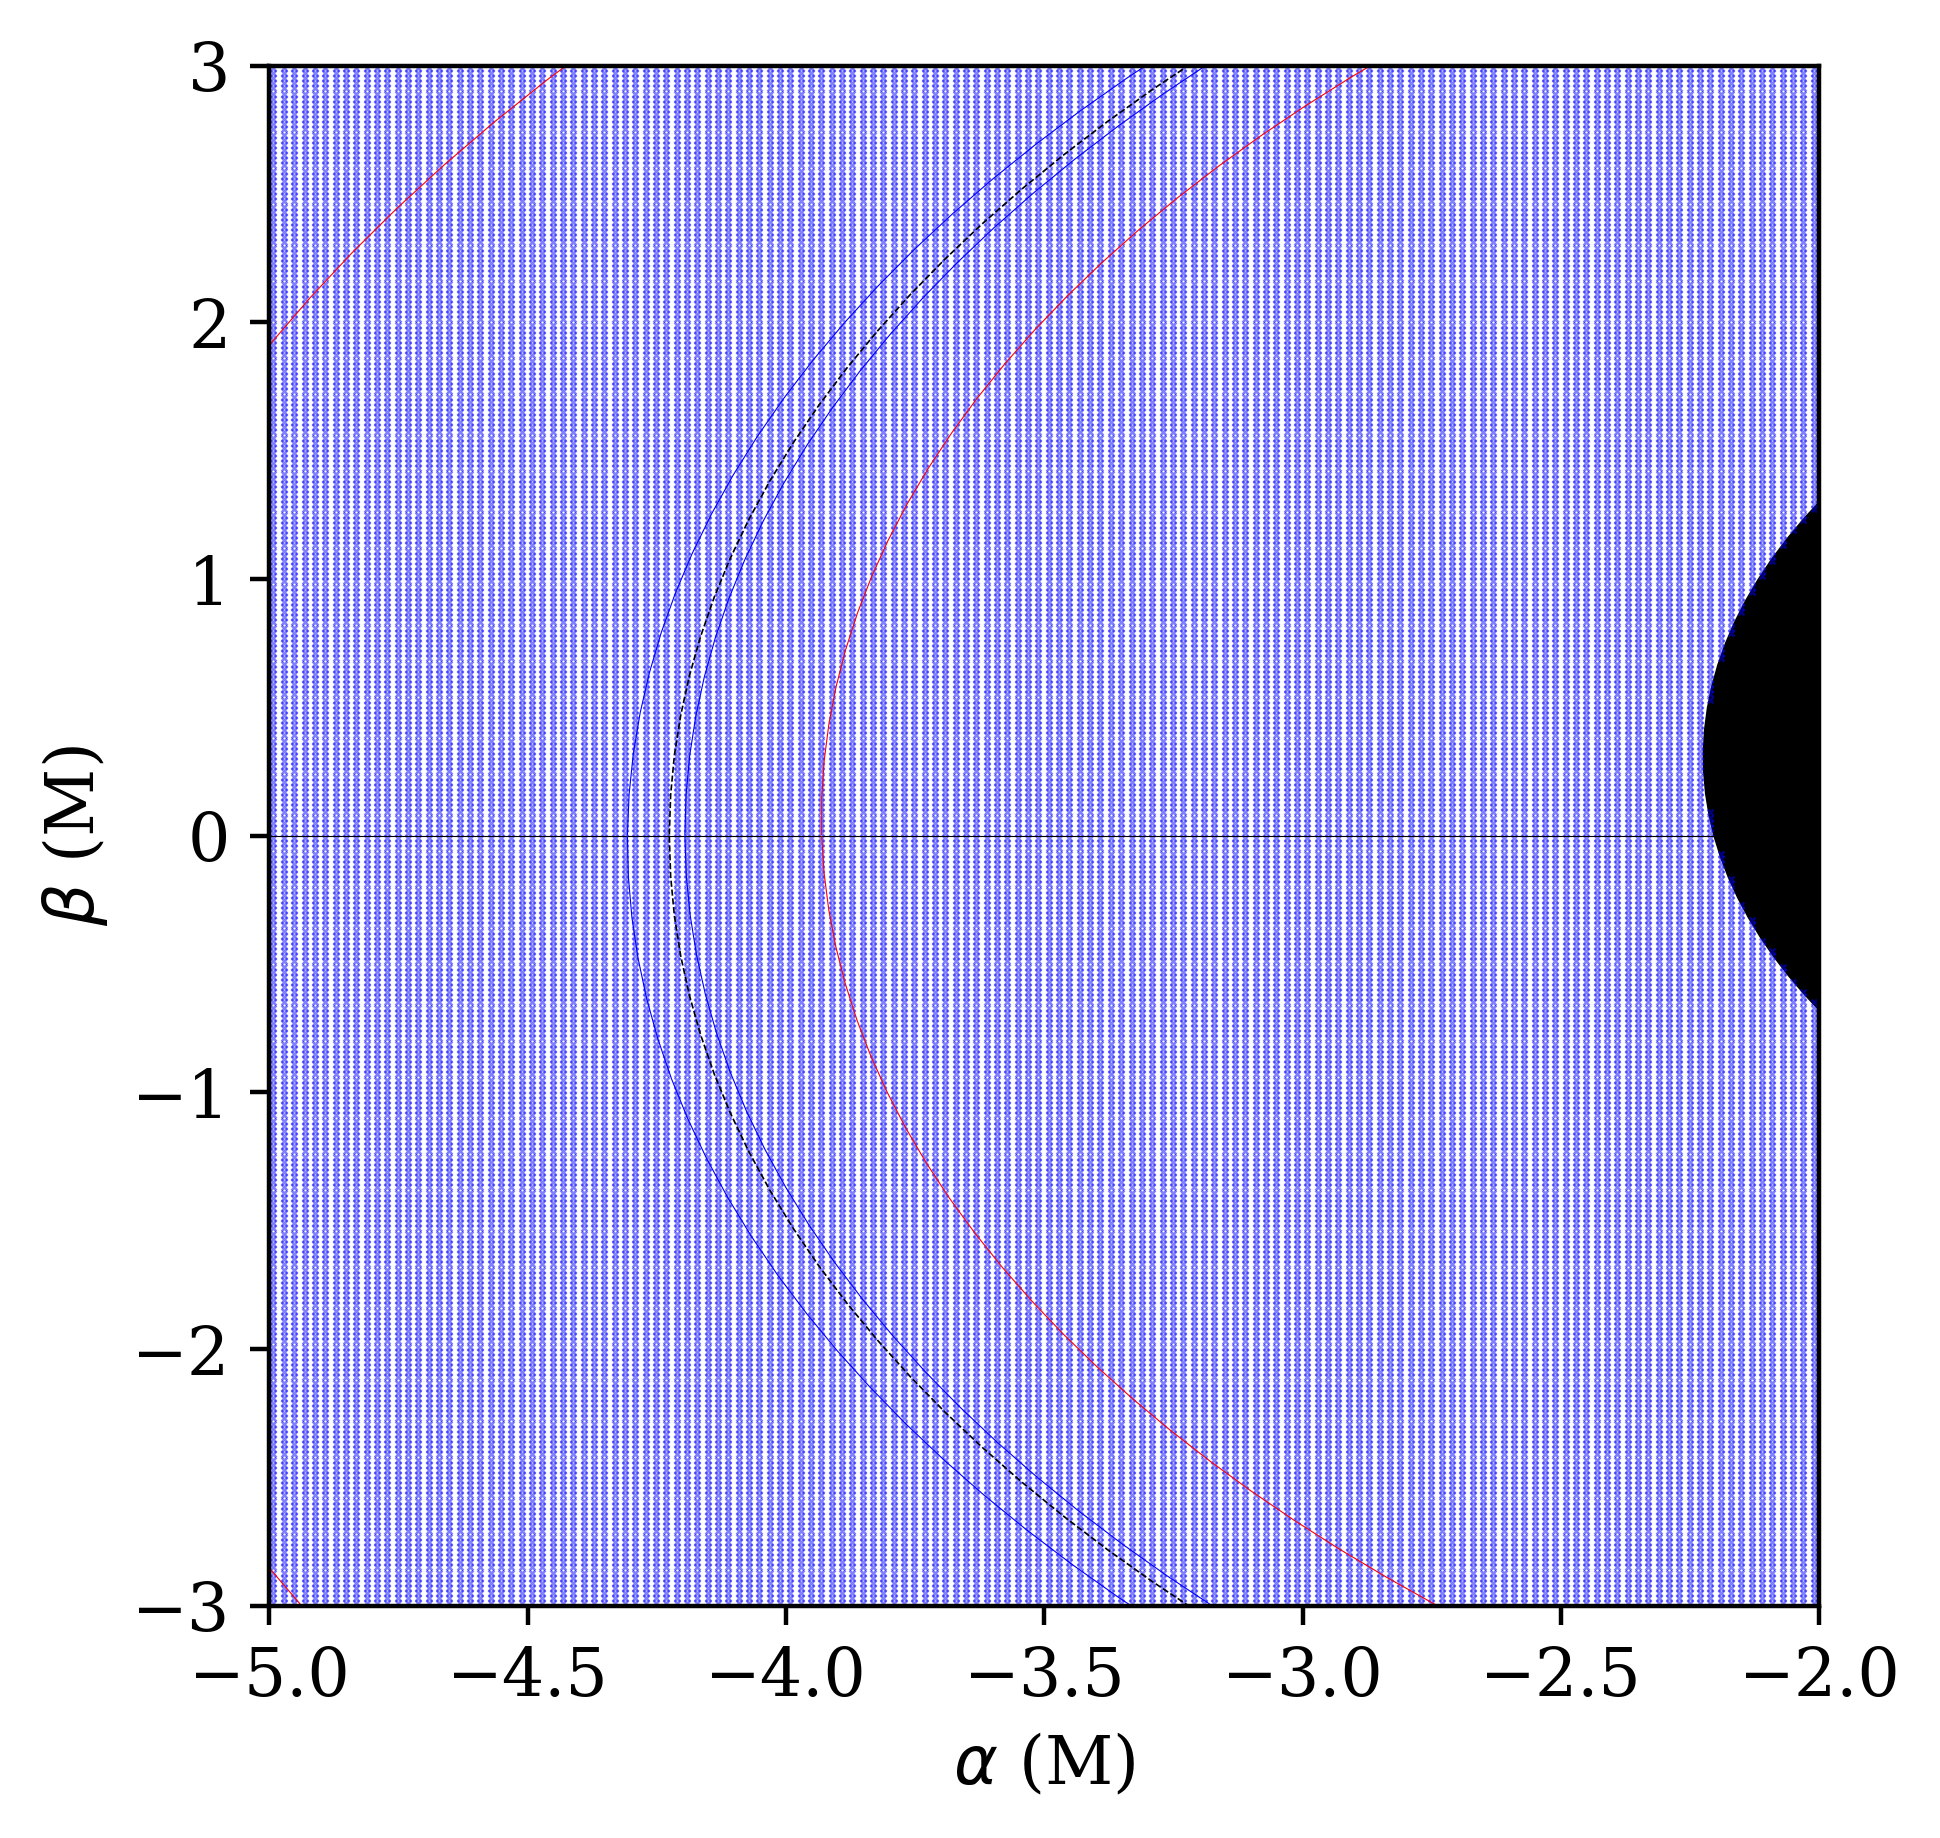

In [55]:
fig, ax = plt.subplots(figsize=[5,5],dpi=400)

ax.axvline(0,color="k",linewidth=0.2)
ax.axhline(0,color="k",linewidth=0.2)

ax.plot(alpha_critc,beta_critc,color="k",linewidth=0.3,linestyle="--")
ax.plot(alpha_critc,-beta_critc,color="k",linewidth=0.3,linestyle="--")

ax.fill(hull_0i[:,0],hull_0i[:,1],color="k")
ax.plot(hull_1i[:,0],hull_1i[:,1],'r',linewidth=0.2)
ax.plot(hull_1e[:,0],hull_1e[:,1],'r',linewidth=0.2)
ax.plot(hull_2i[:,0],hull_2i[:,1],'b',linewidth=0.2)
ax.plot(hull_2e[:,0],hull_2e[:,1],'b',linewidth=0.2)

#Plotting the grid points of the n=1 lensing band
# ax.scatter(supergrid1[:,0][mask1],supergrid1[:,1][mask1],color="r",marker=".",s=.1,alpha=0.5)
ax.scatter(supergrid0[:,0][mask0],supergrid0[:,1][mask0],color="b",marker="x",s=.1,alpha=0.5)
# ax.scatter(supergrid2[:,0][mask2],supergrid2[:,1][mask2],color="c",marker="+",s=.1,alpha=0.5)

# ax.set_xlim(-12,12)
# ax.set_ylim(-12,12)
ax.set_xlim(-5,-2)
ax.set_ylim(-3,3)

ax.set_xlabel(r"$\alpha$"+" "+"(M)")
ax.set_ylabel(r"$\beta$"+" "+"(M)")

#plt.savefig('LB.png',dpi=400,bbox_inches='tight')

plt.show()

# Analytical Ray-tracing

In [56]:
%time !python3 raytracing.py



Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Ray-tracing
Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/LensingBands_a_0.94_i_17.h5
Analytical ray-tracing of the n=0 band points
Analytical ray-tracing of the n=1 band points
Analytical ray-tracing of the n=2 band points
File  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Rays_a_0.94_i_17.h5  created.

A total of 18750000 photons were ray-traced
CPU times: user 1.11 s, sys: 264 ms, total: 1.37 s
Wall time: 1min 18s


In [5]:
# fnrays="./Results/Rays_a_%s_i_%s.h5"%(spin_case,i_case)
fnrays= path + "Rays_a_%s_i_%s.h5"%(spin_case,i_case)

print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

rs0=h5f['rs0'][:]
sign0=h5f['sign0'][:]
t0=h5f['t0'][:]
phi0=h5f['phi0'][:]

rs1=h5f['rs1'][:]
sign1=h5f['sign1'][:]
t1=h5f['t1'][:]
phi1=h5f['phi1'][:]

rs2=h5f['rs2'][:]
sign2=h5f['sign2'][:]
t2=h5f['t2'][:]
phi2=h5f['phi2'][:]


h5f.close()

Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Rays_a_0.94_i_17.h5


## Plotting the $r$ and $\phi$ values of the n=0 band

Text(0, 0.5, '$\\beta$ (M)')

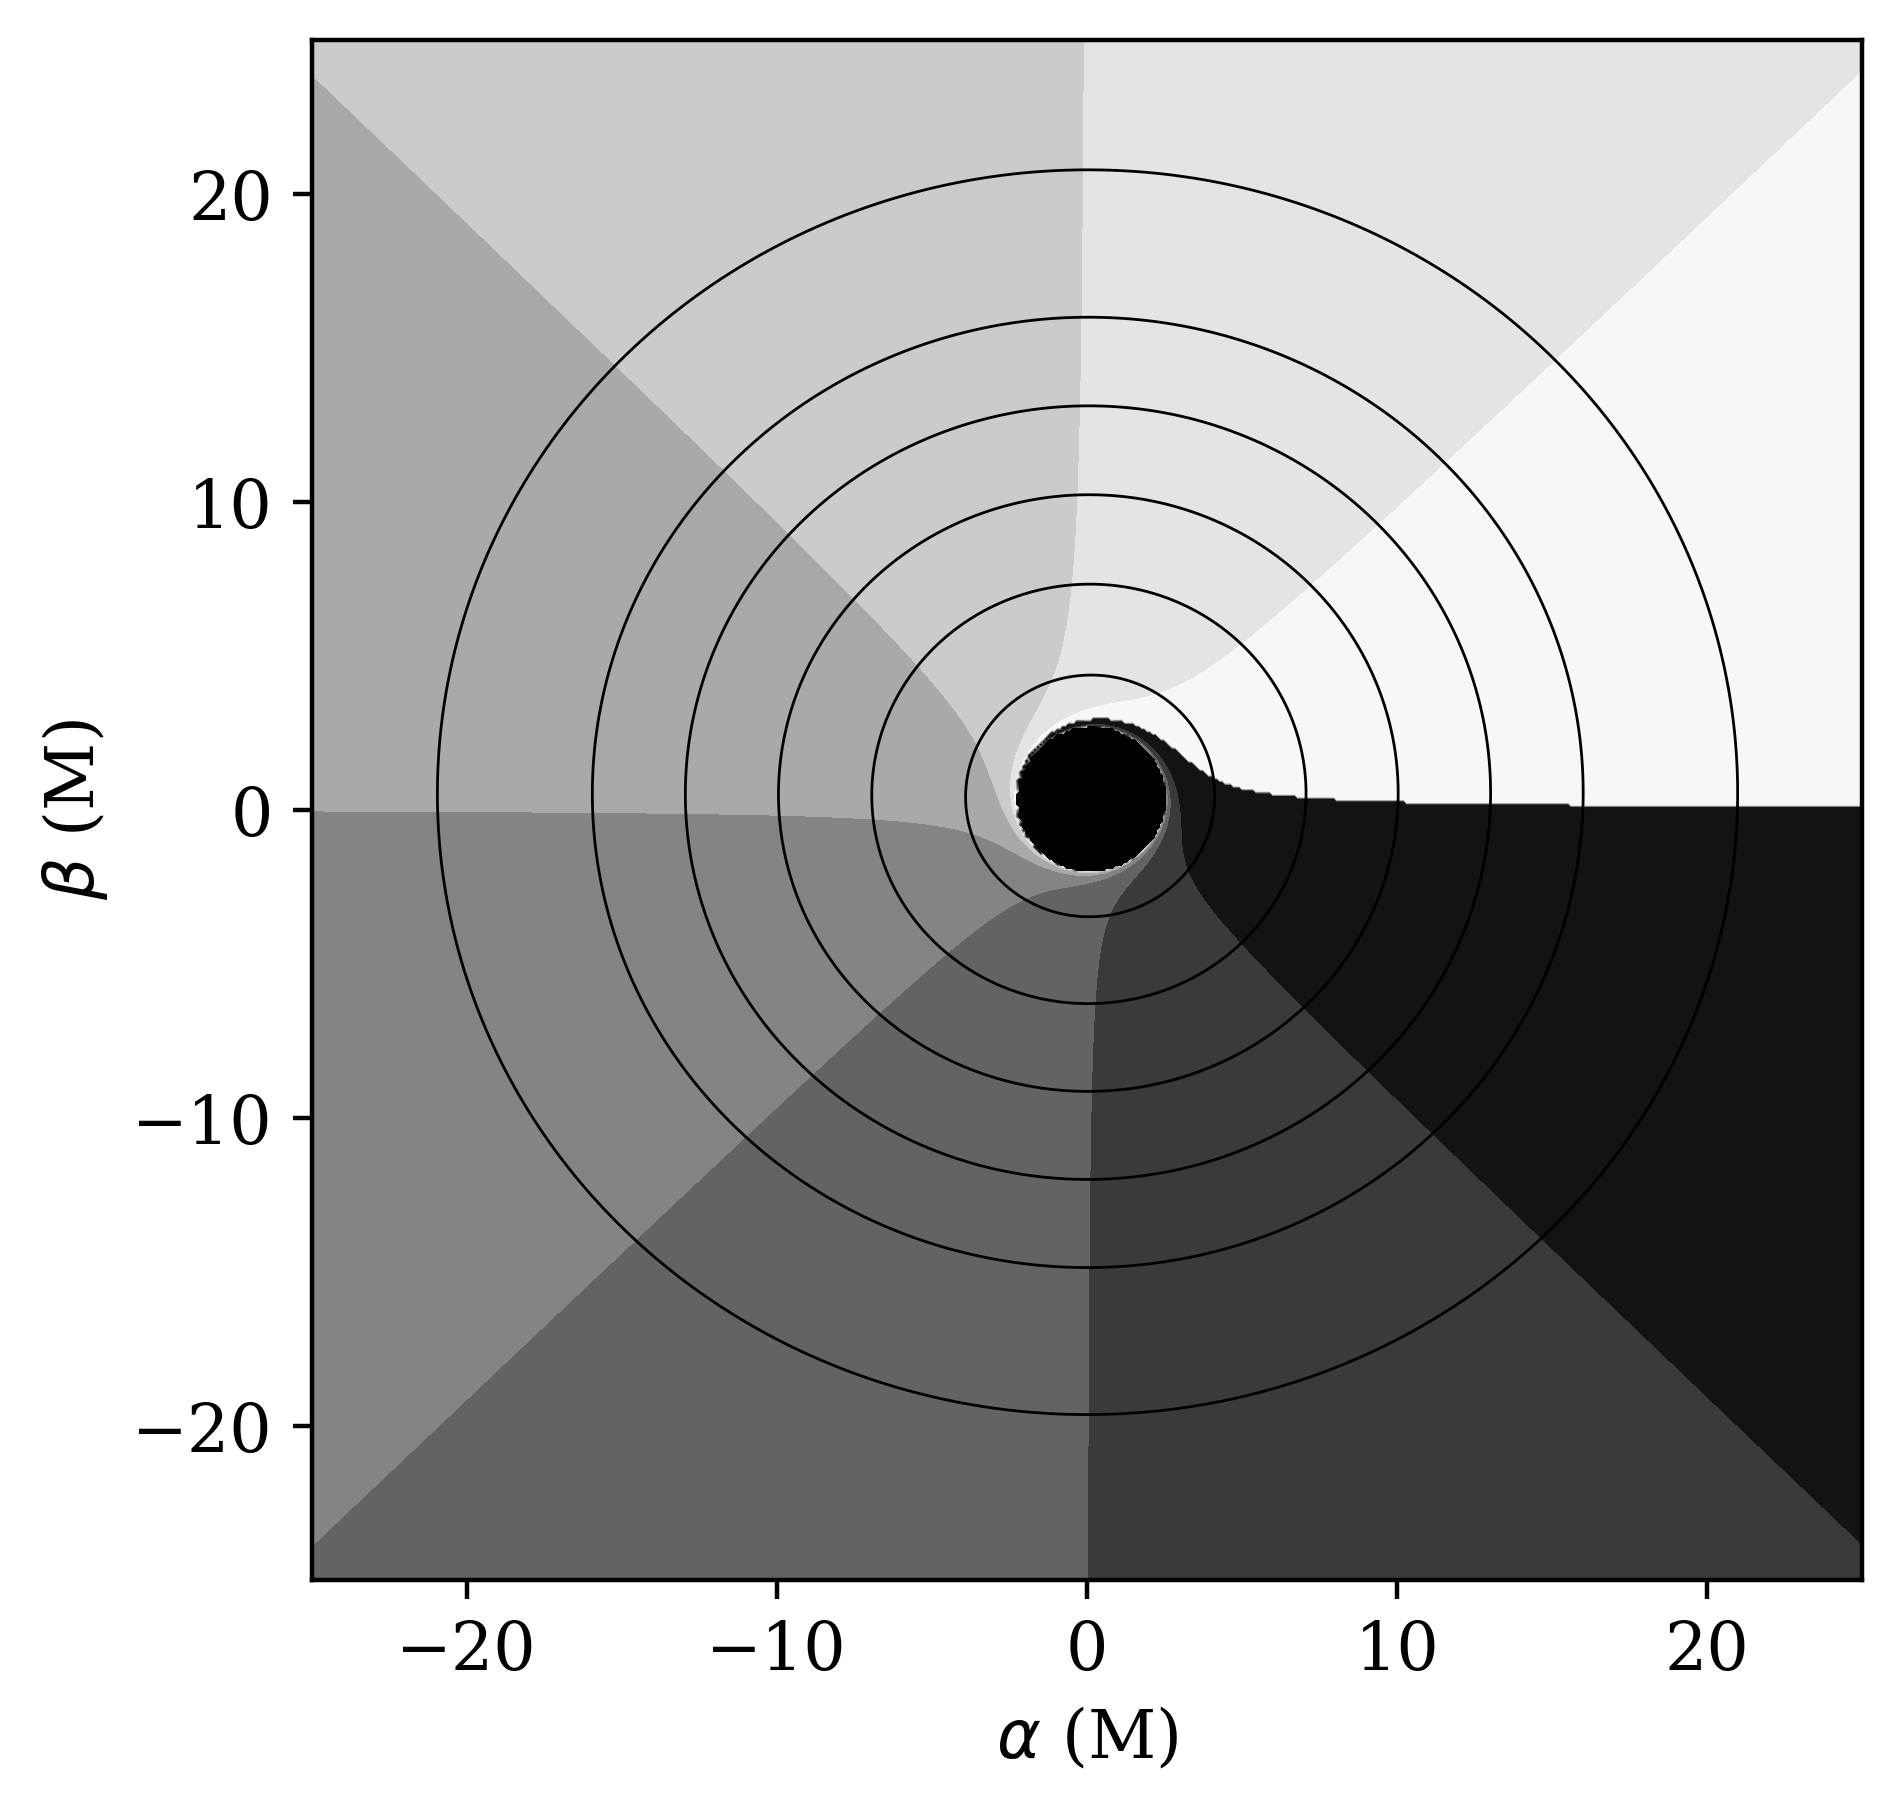

In [26]:
fig, ax = plt.subplots(figsize=[5,5],dpi=400)

ax.fill(hull_0i[:,0],hull_0i[:,1],color="k",linewidth=1,zorder=0)
        
CSphi=ax.contourf(phi0.reshape(N0,N0).T%(2*np.pi),cmap="Greys",levels=np.linspace(0,2*np.pi,9),extent=[-lim0,lim0,-lim0,lim0],origin="lower")
CSr=ax.contour(rs0.reshape(N0,N0).T,levels=[3,6,9,12,15,20],extent=[-lim0,lim0,-lim0,lim0],origin="lower",linewidths=0.5,colors='k')

ax.set_xlim(-lim0,lim0)
ax.set_ylim(-lim0,lim0)

ax.set_xlabel(r"$\alpha$"+" "+"(M)")
ax.set_ylabel(r"$\beta$"+" "+"(M)")

#plt.savefig('Rays.png',dpi=400,bbox_inches='tight')

# Computing images

In [7]:

args = ' '
cmd1_args = {
   	"nu0" : '--nu ',
	"mass" : '--mass ',
	"scale_height" : '--scaleh ',
	"theta_b" : '--thetab ',
	"beta" : '--beta ',
    "r_ie" : '--rie ',
	"rb_0" : '--rb0 ',
	"n_th0" : '--nth0 ',
	"t_e0" : '--te0 ',
	"p_dens" : '--pdens ',
	"p_temp" : '--ptemp ',
    "nscale" : '--nscale ',
}

cmd2_args = {
	"emodelkey" : '--emodelkey ',
    "bkey" : '--bkey ',
    "nnoisykey" : '--nnoisykey ',
    "tnoisykey" : '--tnoisykey ',
    "bnoisykey" : '--bnoisykey ',
}
# brightparams = [
# 	230e9, # nu0
# 	(MMkg * u.kg).to(u.g).value, # mass
# 	.5, # scale_height
# 	50.0 * (np.pi / 180), # theta_b
# 	1.0, # beta
# 	10.0, # Rie
# 	0, # Bchoice
# 	2, # rb
# 	1.0726e+05, # n_th0
# 	1.2428e+11, # t_e0
# 	-.7, # p_dens
# 	-.84 # p_temp
# ]
brightparams = {
    "nu0": 230e9,  # 0 nu0
    "mass": (MMkg * u.kg).to(u.g).value,  # 1 mass
    "scale_height": .5,  # 2 scale_height
    "theta_b": 50.0 * (np.pi / 180),  # 3 theta_b
    "beta": 1.0,  # 4 beta
    "r_ie": 10.0,  # 5 rie
    "rb_0": 2,  # 7 rb_0
    "n_th0": 8e2,  # ,4e5 # 8 n_th0
    "t_e0": 2e11,  # 9 t_e0 1e12
    "p_dens": -.7,  # 10 p_dens
    "p_temp": -.3,  # 11 p_temp
    "nscale": .4  # Scale of Inoisy
}

funckeys = {
		"emodelkey" : 0, # emodelkey Emission Model choice, 0 = thermal ultrarelativistic, 1 = power law
        "bkey" : 2, # bkey
        "nnoisykey" : 0, # nnoisykey Inoisy density. 0 = no noise, 1 = noise
        "tnoisykey" : 0, # tnoisykey Inoisy temperature
        "bnoisykey" : 0# bnoisykey Inoisy magnetic field
}

# brightparams = fpp.bp_steeperT
# funckeys = fpp.fk_fiducial

for arg in cmd1_args:
    args = args + cmd1_args[arg] + str(brightparams[arg]) + ' ' 

for arg in cmd2_args:
    args = args + cmd2_args[arg] + str(funckeys[arg]) + ' ' 
    
# for i in range(len(brightparams)):
#     args = args + cmd1_args[i] + str(brightparams[i]) + ' '
aartpath = '/home/tej/Desktop/Code_Stuff/Repositories/aart'

In [2]:
subprocess.run(['python3 ' + aartpath + '/radialintensity.py' + args], shell=True)


NameError: name 'subprocess' is not defined

In [8]:
# TODO: modify name
# fnrays='./Results/Intensity_a_{}|i_{}|nu_{}|mass_{}|scaleh_{}|thetab_{}|beta_{}|rie_{}|rb_{}|nth0_{}|te0_{}|pdens_{}|ptemp_{}|nscale_{}|emkey_{}|bkey_{}|nkey_{}|tnke
fnrays= path + 'Intensity_a_{}_i_{}_nu_{}_mass_{}_scaleh_{}_thetab_{}_beta_{}_rie_{}_rb_{}_nth0_{}_te0_{}_pdens_{}_ptemp_{}_nscale_{}_emkey_{}_bkey_{}_nkey_{}_tnkey_{}_bnkey_{}.h5'.format(
    spin_case,
    i_case,
    "{:.5e}".format(brightparams["nu0"]),
    "{:.5e}".format(brightparams["mass"]), 
    float(brightparams["scale_height"]),
    "{:.3f}".format(brightparams["theta_b"]), 
    "{:.2f}".format(float(brightparams["beta"])),
    "{:.1f}".format(float(brightparams["r_ie"])), 
    "{:.1f}".format(float(brightparams["rb_0"])),
    "{:.1e}".format(brightparams["n_th0"]),
    "{:.1e}".format(brightparams["t_e0"]),
    float(brightparams["p_dens"]),
    float(brightparams["p_temp"]),
    "{:.1f}".format(brightparams["nscale"]),
    funckeys["emodelkey"],
    funckeys["bkey"],
    funckeys["nnoisykey"],
    funckeys["tnoisykey"],
    funckeys["bnoisykey"]
    )
    
print("Reading file: ",fnrays)

h5f = h5py.File(fnrays,'r')

I0=h5f['bghts0'][:] # This implies I0 is 1 pass
I1=h5f['bghts1'][:]
I2=h5f['bghts2'][:]

I2_Absorb = h5f['bghts2_absorbtion'][:]
I1_Absorb = h5f['bghts1_absorbtion'][:]
I0_Absorb = h5f['bghts0_absorbtion'][:]
Absorbtion_Image =h5f['bghts_full_absorbtion'][:]
tau2 = h5f['tau2'][:]
tau1 = h5f['tau1'][:]
tau0 = h5f['tau0'][:]
full_profiles0 = h5f['full_profiles0'][:]
full_profiles1 = h5f['full_profiles1'][:]
full_profiles2 = h5f['full_profiles2'][:]
full_profiles_unit = h5f['full_profiles_unit'][:]

cosAng2 = h5f['cosAngReturn2'][:]
cosAng1 = h5f['cosAngReturn1'][:]
cosAng0 = h5f['cosAngReturn0'][:]


testa0 = h5f['testa0'][:]
testb0 = h5f['testb0'][:]
eta0 = h5f['eta0'][:]

h5f.close()

full_profiles_unit[3].decode('UTF-8')
for i in range (len(full_profiles_unit)):
    full_profiles_unit[i] = full_profiles_unit[i].decode('UTF-8')

Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Intensity_a_0.94_i_17_nu_2.30000e+11_mass_1.32497e+43_scaleh_0.5_thetab_0.873_beta_1.00_rie_10.0_rb_2.0_nth0_8.0e+02_te0_2.0e+11_pdens_-0.7_ptemp_-0.3_nscale_0.4_emkey_0_bkey_2_nkey_0_tnkey_0_bnkey_0.h5


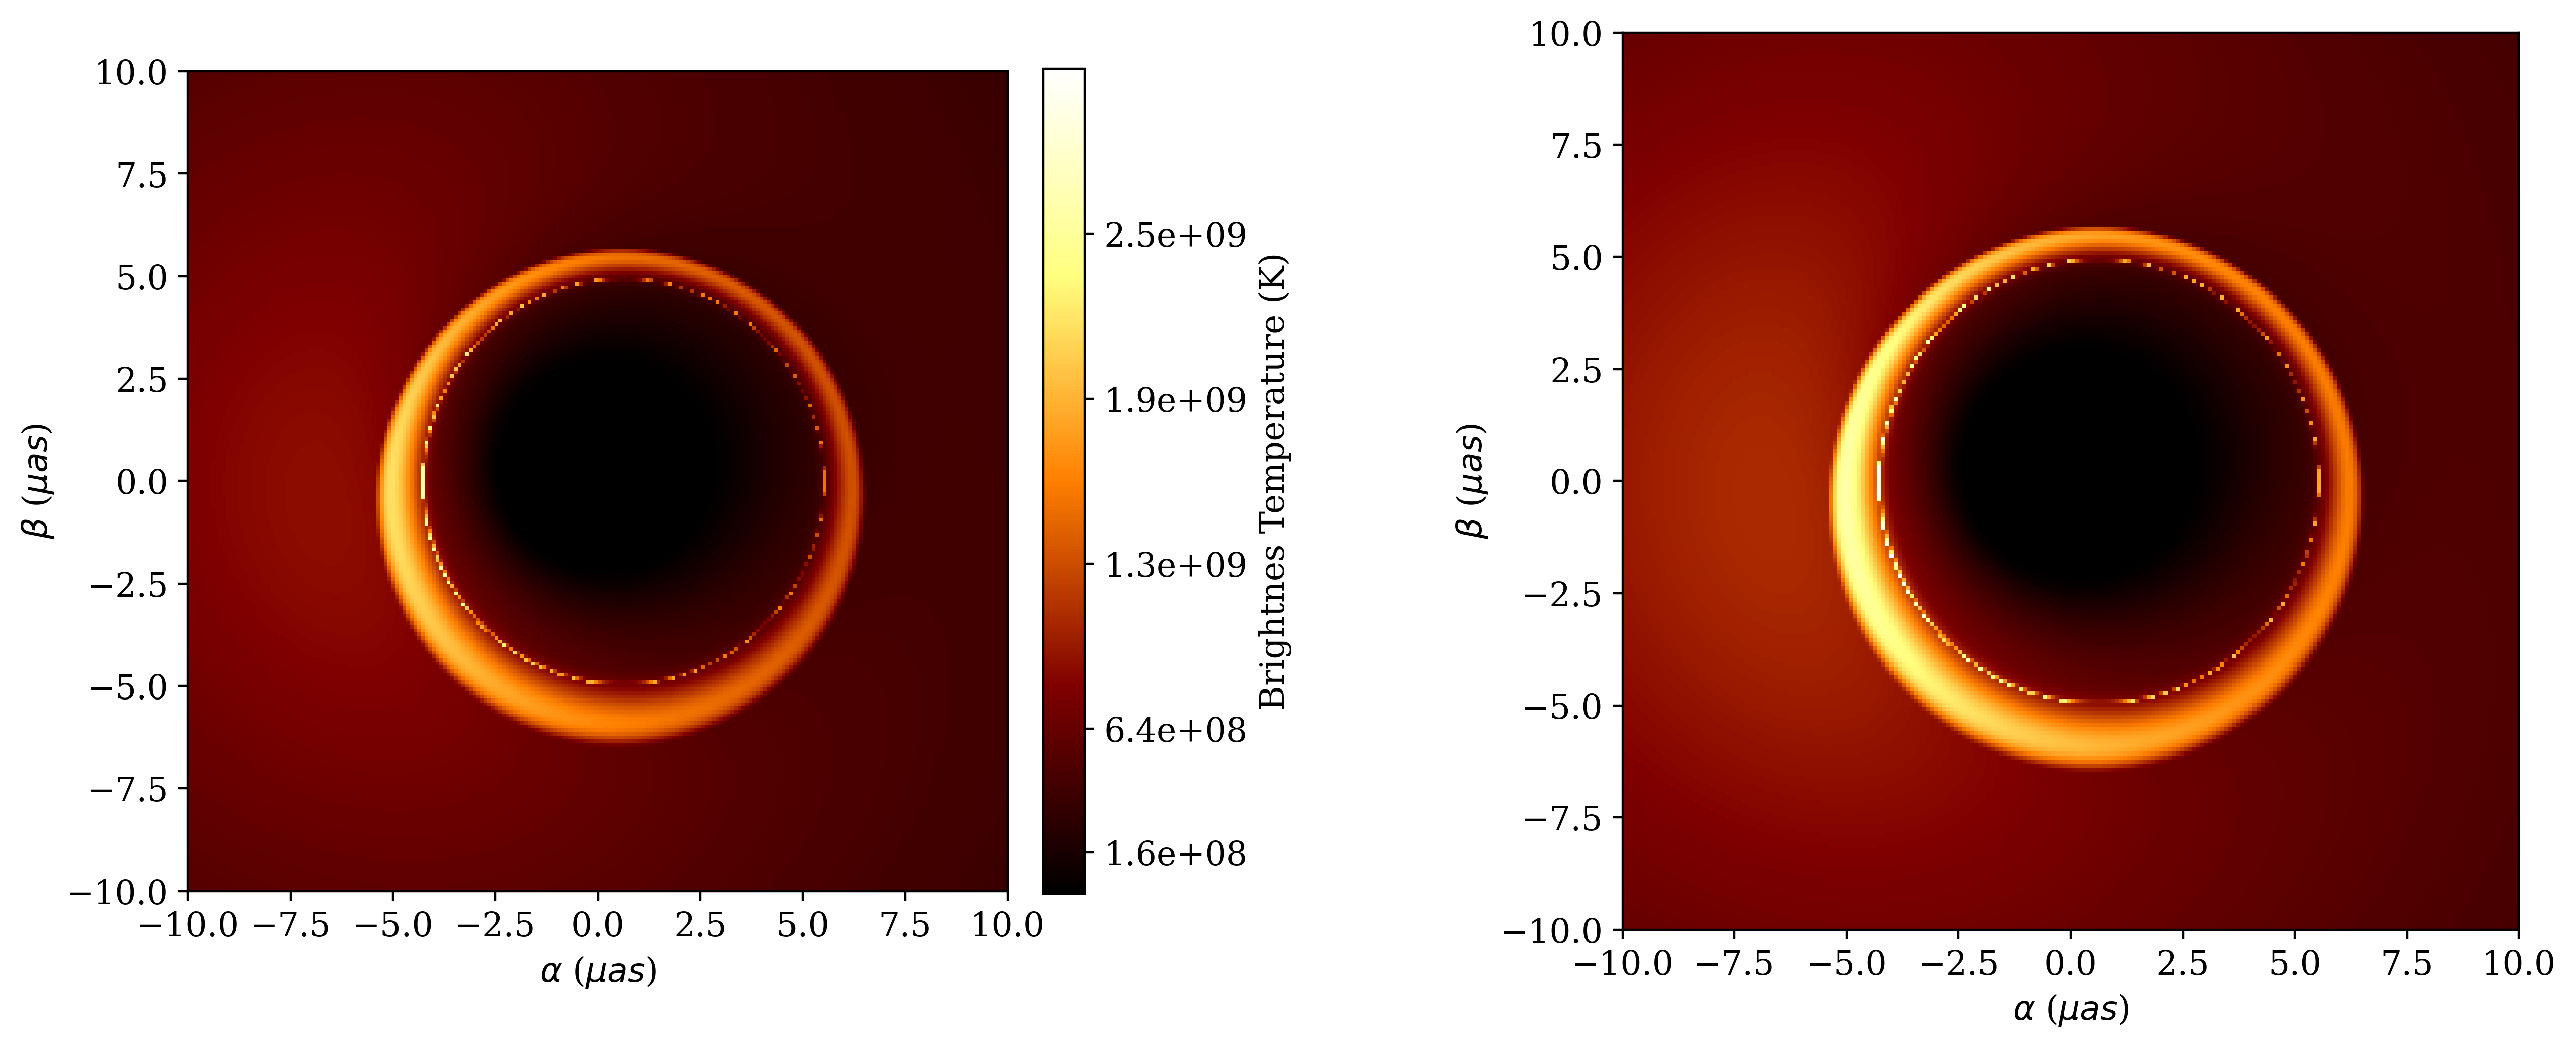

total thin flux:  0.5031051215487371 Jy
total thick flux:  0.5019651503353058 Jy


In [154]:
# one_M = ilp.rg_func(brightparams[1] * u.g).to(u.m)
# M2rads = np.arctan(one_M.value / dBH)
# M2uas = np.arctan(one_M.value / dBH)/muas_to_rad
# Mass distance units of 1 = .5842 uas
# Absorption
vmax0 = np.nanmax(I0+I1+I2)*1.2
vmin = np.nanmax(I0+I1+I2)*.5
fig, (ax0, ax1) = plt.subplots(1,2,figsize=[15,7],dpi=400)
#im = ax.imshow(I0+I1+I2,vmax=np.max(I0+I1+I2)*1.2,origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])
#im = ax.imshow(I0+I1+I2,origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0],norm=matplotlib.colors.PowerNorm(.7,vmax=vmax))

im0 = ax0.imshow(I0 + I1 + I2,vmax=vmax0, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])
# im0 = ax0.imshow(scipy.ndimage.gaussian_filter(I0 + I1 + I2, sigma=2),vmax=vmax0, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])
# 
ax0.set_xlim(-10,10) # units of M
ax0.set_ylim(-10,10) 
    
    
ax0.set_xlabel(r"$\alpha$"+" "+r"($\mu as$)")
ax0.set_ylabel(r"$\beta$"+" "+r"($\mu as$)")

# vmax1 = Absorbtion_Image.nanmax()*1.2
# im1 = ax1.imshow(I1_Absorb + I2_Absorb + Absorbtion_Image,vmax=vmax0, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])
im1 = ax1.imshow(Absorbtion_Image, origin="lower",cmap="afmhot",extent=[-lim0,lim0,-lim0,lim0])

# 
ax1.set_xlim(-10,10) # units of M
ax1.set_ylim(-10,10) 
    
    
ax1.set_xlabel(r"$\alpha$"+" "+r"($\mu as$)")
ax1.set_ylabel(r"$\beta$"+" "+r"($\mu as$)")



colorbar0=fig.colorbar(im0, fraction=0.046, pad=0.04, format='%.1e', ticks=[
    vmax0*.8,
    vmax0*.6,
    vmax0*.4,
    vmax0*.2,
    vmax0*.05
    ],
    label="Brightnes Temperature (K)",
    ax=ax0
    )

# colorbar1=fig.colorbar(im1, fraction=0.046, pad=0.04, format='%.1e', ticks=[
#     vmax1*.8,
#     vmax1*.6,
#     vmax1*.4,
#     vmax1*.2,
#     vmax1*.05
#     ],
#     label="Brightnes Temperature (K)",
#     ax=ax1
#     )
plt.subplots_adjust(wspace=.6)
size = 100
'''Radii Calc'''
radius, theta = tls.radii_of_theta(I0,size)
# theta = np.arange(2*np.pi + 1, step=(2*np.pi + 1) / 100)
radius1, theta1 = tls.radii_of_theta(I1,size)
radius2, theta2 = tls.radii_of_theta(I2,size)

alpha =  radius * np.cos(theta)
beta =  radius * np.sin(theta)
alpha1 =  radius1 * np.cos(theta)
beta1 =  radius1 * np.sin(theta)
alpha2 =  radius2 * np.cos(theta)
beta2 =  radius2 * np.sin(theta)

# ax0.plot(alpha, beta, 'b')
# ax0.plot(alpha1, beta1, 'or')
# plt.plot(alphas_inner, betas_inner, '--c')
# plt.plot(alphas_outer, betas_outer, '--m')

# theta = np.arange(2*np.pi + 1, step=(2*np.pi + 1)/100)
# radii = np.array(tls.radii_of_theta(I0,100)) /100
# beta =  radii * np.sin(theta)
# alpha =  radii * np.cos(theta)
# plt.plot(alpha, beta, 'r')



# plt.savefig(
#     path_sub + 'images/low_rez/Dual_BHImage_a_{}|i_{}|nu_{}|mass_{}|scaleh_{}|thetab_{}|beta_{}|rie_{}|rb_{}|nth0_{}|te0_{}|pdens_{}|ptemp_{}|nscale_{}|emkey_{}|bkey_{}|nkey_{}|tnkey_{}|bnkey_{}.png'.format(
#     spin_case,
#     i_case,
#     "{:.1e}".format(brightparams["nu0"]),
#     "{:.1e}".format(brightparams["mass"]), 
#     float(brightparams["scale_height"]),
#     "{:.3f}".format(brightparams["theta_b"]), 
#     "{:.2f}".format(float(brightparams["beta"])),
#     "{:.1f}".format(float(brightparams["r_ie"])), 
#     "{:.1f}".format(float(brightparams["rb_0"])),
#     "{:.1e}".format(brightparams["n_th0"]),
#     "{:.1e}".format(brightparams["t_e0"]),
#     float(brightparams["p_dens"]),
#     float(brightparams["p_temp"]),
#     "{:.1f}".format(brightparams["nscale"]),
#     funckeys["emodelkey"],
#     funckeys["bkey"],
#     funckeys["nnoisykey"],
#     funckeys["tnoisykey"],
#     funckeys["bnoisykey"]
#     ), bbox_inches='tight'
# )

plt.show()
print("total thin flux: ", ilp.total_jy(I0 + I1 + I2, brightparams["nu0"], brightparams["mass"]))
print("total thick flux: ", ilp.total_jy(Absorbtion_Image, brightparams["nu0"], brightparams["mass"]))

# Profile Plots

In [94]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot


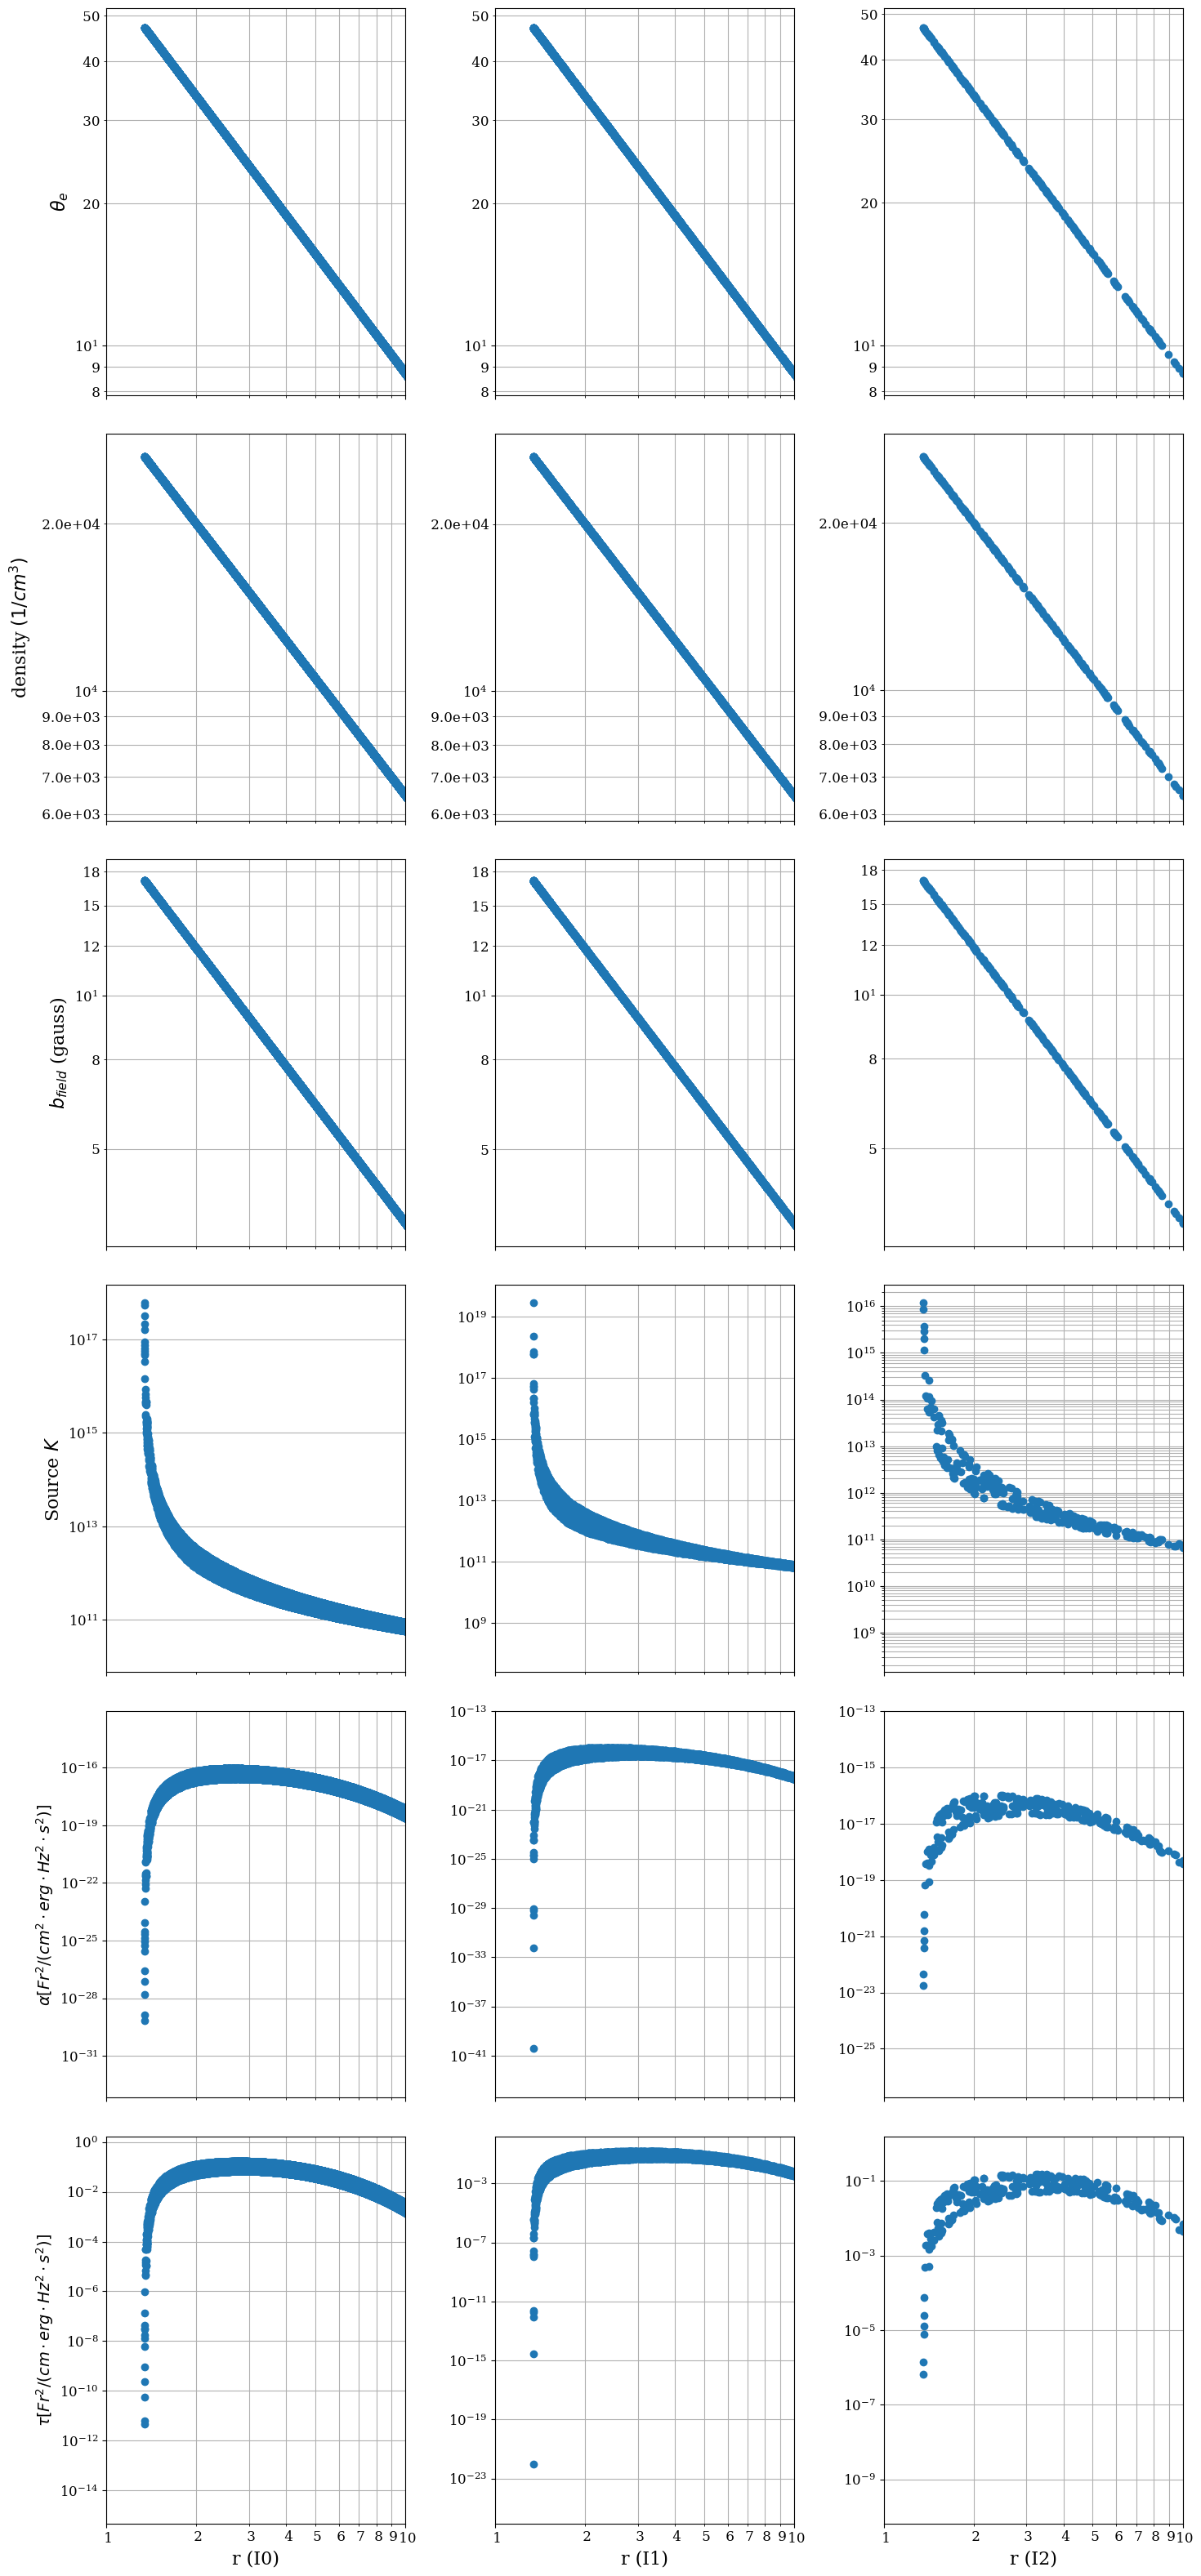

In [40]:


'''

[0,:] ; r
[0,:] ; theta_e
[0,:] ; n
[0,:] ; b_field
[0,:] ; b_nu
[0,:] ; absorptionCoeff
[0,:] ; tau_curv

'''
fig= plt.subplots(6,3,figsize=[17,40], sharex='col')
axs = [
    None, None, None, None, None, None, # Column 1
    None, None, None, None, None, None, # Column 2
    None, None, None, None, None, None  # Colum 3
      ]

line = [
    None, None, None, None, None, None, # Column 1
    None, None, None, None, None, None, # Column 2
    None, None, None, None, None, None  # Colum 3
      ]

b = 1
c = 0
xmin=1
xmax=10
for i in range(1,len(axs),3):
    axs[c] = plt.subplot(6,3,i)
    line[c], = axs[c].plot(full_profiles0[0,:],full_profiles0[b,:], "o")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([xmin,xmax])
    plt.grid(True)
    if (c!=3):
        plt.grid(which='minor')
    b = b + 1
    c = c + 1

b = 1
c = 0
for i in range(1,len(axs),3):
    axs[c+6] = plt.subplot(6,3,i+1)
    line[c+6], = axs[c+6].plot(full_profiles1[0,:],full_profiles1[b,:], "o")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([xmin,xmax])
    plt.grid()
    plt.grid(which='minor')
    b = b + 1
    c = c + 1


b = 1
c = 0
for i in range(1,len(axs),3):
    axs[c+12] = plt.subplot(6,3,i+2)
    line[c+12], = axs[c+12].plot(full_profiles2[0,:],full_profiles2[b,:], "o")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim([xmin,xmax])
    plt.grid()
    plt.grid(which='minor')
    b = b + 1
    c = c + 1
    
plt.subplots_adjust(hspace=.1,
                    wspace=.3)

ylabels = [R"$\theta_e$", R"density $(1/cm^3)$", R"$b_{field}$ (gauss)", R"Source $K$",
           R"$\alpha [Fr^2 / (cm^2 \cdot erg \cdot Hz^2 \cdot s^2)]$", R"$\tau [Fr^2 / (cm \cdot erg \cdot Hz^2 \cdot s^2)]$"]
for i in range(len(ylabels)):
    axs[i].set_ylabel(ylabels[i], fontsize=16)
    
axs[4].set_ylabel(ylabels[4], fontsize=14)
axs[5].set_ylabel(ylabels[5], fontsize=14)
    
# xlabeling
axs[5].set_xlabel("r (I0)", fontsize=16)
axs[5].xaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.f'))
axs[5].xaxis.set_minor_formatter(ticker.FormatStrFormatter('% 1.f'))

axs[11].set_xlabel("r (I1)", fontsize=16)
axs[11].xaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.f'))
axs[11].xaxis.set_minor_formatter(ticker.FormatStrFormatter('% 1.f'))

axs[17].set_xlabel("r (I2)", fontsize=16)
axs[17].xaxis.set_major_formatter(ticker.FormatStrFormatter('% 1.f'))
axs[17].xaxis.set_minor_formatter(ticker.FormatStrFormatter('% 1.f'))

# ylabeling
for i in range(0,len(axs), 6):
    # axs[i].set_ylim([line[i].get_ydata().min(),line[i].get_ydata().max()])
    x = line[i].get_xdata()
    y = line[i].get_ydata()
    y = y[np.logical_and(x>=xmin,x<=xmax)]
    
    axs[i].set_ylim([y.min()*.9,y.max()*1.1])
    axs[i].yaxis.set_minor_formatter(ticker.FormatStrFormatter('% 1.f')) 
    
    x = line[i+1].get_xdata()
    y = line[i+1].get_ydata()
    y = y[np.logical_and(x>=xmin,x<=xmax)]
    axs[i+1].set_ylim([y.min()*.9,y.max()*1.1])
    axs[i+1].yaxis.set_minor_formatter(ticker.FormatStrFormatter('% .1e')) 
    
    x = line[i+2].get_xdata()
    y = line[i+2].get_ydata()
    y = y[np.logical_and(x>=xmin,x<=xmax)]
    axs[i+2].set_ylim([y.min()*.9,y.max()*1.1])
    axs[i+2].yaxis.set_minor_formatter(ticker.FormatStrFormatter('% 1.f')) 
    axs[i+2].yaxis.set_minor_locator(plt.MaxNLocator(7))
    

for i in range(0,len(axs), 6):
    # axs[i].set_ylim([line[i].get_ydata().min(),line[i].get_ydata().max()])
    x = line[i+4].get_xdata()
    y = line[i+4].get_ydata()
    y = y[np.logical_and(x>=xmin,x<=xmax)]
    
    axs[i+4].set_ylim([y.min()*10e-5,y.max()*10e2])
    
    x = line[i+5].get_xdata()
    y = line[i+5].get_ydata()
    y = y[np.logical_and(x>=xmin,x<=xmax)]
    
    axs[i+5].set_ylim([y.min()*10e-5,y.max()*1e1])
    
# axs[0].yaxis.set_minor_formatter(ticker.FormatStrFormatter('% 1.f')) 
# 
# axs[6].yaxis.set_minor_locator(plt.MaxNLocator(7))
# axs[6].yaxis.set_minor_formatter(ticker.FormatStrFormatter('% 1.f'))   

# axs[1].yaxis.set_minor_formatter(ticker.FormatStrFormatter('% .1e'))
# axs[2].yaxis.set_minor_formatter(ticker.FormatStrFormatter('% 1.f'))


plt.savefig(
    path_sub + 'images/low_rez/graph_BHImage_a_{}|i_{}|nu_{}|mass_{}|scaleh_{}|thetab_{}|beta_{}|rie_{}|rb_{}|nth0_{}|te0_{}|pdens_{}|ptemp_{}|nscale_{}|emkey_{}|bkey_{}|nkey_{}|tnkey_{}|bnkey_{}.png'.format(
    spin_case,
    i_case,
    "{:.1e}".format(brightparams["nu0"]),
    "{:.1e}".format(brightparams["mass"]), 
    float(brightparams["scale_height"]),
    "{:.3f}".format(brightparams["theta_b"]), 
    "{:.2f}".format(float(brightparams["beta"])),
    "{:.1f}".format(float(brightparams["r_ie"])), 
    "{:.1f}".format(float(brightparams["rb_0"])),
    "{:.1e}".format(brightparams["n_th0"]),
    "{:.1e}".format(brightparams["t_e0"]),
    float(brightparams["p_dens"]),
    float(brightparams["p_temp"]),
    "{:.1f}".format(brightparams["nscale"]),
    funckeys["emodelkey"],
    funckeys["bkey"],
    funckeys["nnoisykey"],
    funckeys["tnoisykey"],
    funckeys["bnoisykey"]
    ), bbox_inches='tight'
)
plt.show()

    

# G function tests

In [17]:
# Assume d log is natural log, & is for end of line
gxvalsarray = np.array([1.e-6, 1.12202e-6, 1.25893e-6, 1.41254e-6, 1.58489e-6, 1.77828e-6, 1.99526e-6, 2.23872e-6, 2.51189e-6,2.81838e-6, 3.16228e-6, 3.54813e-6, 3.98107e-6, 
              4.46684e-6, 5.01187e-6, 5.62341e-6, 6.30957e-6, 7.07946e-6, 7.94328e-6, 8.91251e-6, 0.00001e0, 0.0000112202e0, 0.0000125893e0, 0.0000141254e0,
              0.0000158489e0, 0.0000177828e0, 0.0000199526e0, 0.0000223872e0, 0.0000251189e0, 0.0000281838e0, 0.0000316228e0, 0.0000354813e0, 0.0000398107e0,
              0.0000446684e0, 0.0000501187e0, 0.0000562341e0, 0.0000630957e0, 0.0000707946e0, 0.0000794328e0, 0.0000891251e0, 0.0001e0, 0.000112202e0, 0.000125893e0, 
              0.000141254e0, 0.000158489e0, 0.000177828e0, 0.000199526e0, 0.000223872e0, 0.000251189e0, 0.000281838e0, 0.000316228e0, 0.000354813e0, 0.000398107e0, 0.000446684e0,
              0.000501187e0, 0.000562341e0, 0.000630957e0, 0.000707946e0, 0.000794328e0, 0.000891251e0, 0.001e0, 0.00112202e0, 0.00125893e0, 0.00141254e0, 
              0.00158489e0, 0.00177828e0, 0.00199526e0, 0.00223872e0, 0.00251189e0, 0.00281838e0, 0.00316228e0, 0.00354813e0, 0.00398107e0, 0.00446684e0, 0.00501187e0,
              0.00562341e0, 0.00630957e0, 0.00707946e0, 0.00794328e0, 0.00891251e0, 0.01e0, 0.0112202e0, 0.0125893e0, 0.0141254e0, 0.0158489e0, 0.0177828e0,
              0.0199526e0, 0.0223872e0, 0.0251189e0, 0.0281838e0, 0.0316228e0, 0.0354813e0, 0.0398107e0, 0.0446684e0, 0.0501187e0, 0.0562341e0, 0.0630957e0, 0.0707946e0,
              0.0794328e0, 0.0891251e0, 0.1e0, 0.112202e0, 0.125893e0, 0.141254e0, 0.158489e0, 0.177828e0, 0.199526e0, 0.223872e0, 0.251189e0, 0.281838e0, 0.316228e0, 0.354813e0, 0.398107e0, 0.446684e0,
              0.501187e0, 0.562341e0, 0.630957e0, 0.707946e0, 0.794328e0, 0.891251e0, 1e0, 1.12202e0, 1.25893e0, 1.41254e0, 1.58489e0, 1.77828e0, 1.99526e0, 2.23872e0, 2.51189e0, 2.81838e0, 
              3.16228e0, 3.54813e0, 3.98107e0, 4.46684e0, 5.01187e0, 5.62341e0, 6.30957e0, 7.07946e0, 7.94328e0, 8.91251e0, 10e0, 11.2202e0, 12.5893e0, 14.1254e0, 15.8489e0, 
              17.7828e0, 19.9526e0, 22.3872e0, 25.1189e0, 28.1838e0, 31.6228e0, 35.4813e0, 39.8107e0, 44.6684e0, 50.1187e0, 56.2341e0, 63.0957e0, 70.7946e0, 79.4328e0, 
              89.1251e0, 100e0, 112.202e0, 125.893e0, 141.254e0, 158.489e0, 177.828e0, 199.526e0, 223.872e0, 251.189e0, 281.838e0, 316.228e0, 354.813e0, 398.107e0, 446.684e0, 
              501.187e0, 562.341e0, 630.957e0, 707.946e0, 794.328e0, 891.251e0, 1000e0])
gxvals=np.log(gxvalsarray)




In [18]:
xvalsarray = np.array([1.e-6, 1.25893e-6, 1.58489e-6, 1.99526e-6, 2.51189e-6,3.16228e-6, 3.98107e-6, 5.01187e-6, 6.30957e-6, 7.94328e-6, 0.00001e0, 0.0000125893e0, 0.0000158489e0, 0.0000199526e0,
          0.0000251189e0, 0.0000316228e0, 0.0000398107e0, 0.0000501187e0, 0.0000630957e0, 0.0000794328e0, 0.0001e0, 0.000125893e0, 0.000158489e0, 0.000199526e0, 
          0.000251189e0, 0.000316228e0, 0.000398107e0, 0.000501187e0, 0.000630957e0, 0.000794328e0, 0.001e0, 0.00125893e0, 0.00158489e0, 0.00199526e0, 0.00251189e0, 
          0.00316228e0, 0.00398107e0, 0.00501187e0, 0.00630957e0, 0.00794328e0, 0.01e0, 0.0125893e0, 0.0158489e0, 0.0199526e0, 0.0251189e0, 0.0316228e0, 0.0398107e0, 
          0.0501187e0, 0.0630957e0, 0.0794328e0, 0.1e0, 0.125893e0, 0.158489e0, 0.199526e0, 0.251189e0, 0.316228e0, 0.398107e0, 0.501187e0, 0.630957e0, 0.794328e0, 1e0, 
          1.25893e0, 1.58489e0, 1.99526e0, 2.51189e0, 3.16228e0, 3.98107e0, 5.01187e0, 6.30957e0, 7.94328e0, 10e0, 12.5893e0, 15.8489e0, 19.9526e0, 25.1189e0, 31.6228e0, 
          39.8107e0, 50.1187e0, 63.0957e0, 79.4328e0, 100e0])
xvals=np.log(xvalsarray)

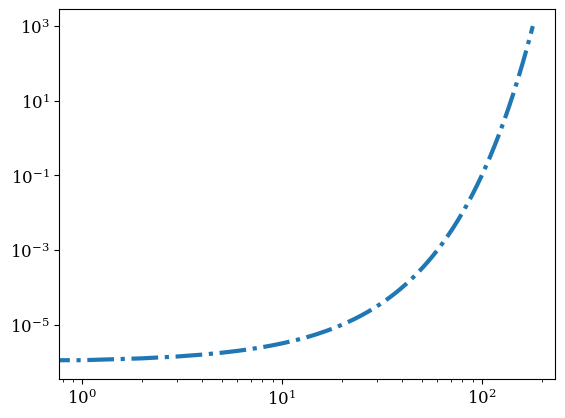

In [32]:
plt.plot(gxvalsarray,linewidth=3, linestyle="-.")
plt.xscale('log')
plt.yscale('log')

# Final Paper Figures

In [13]:
fig_path = "/home/tej/Desktop/Code_Stuff/Repositories/aart_results/Final_Paper/Figs/"

### Emissions Figure

In [49]:
file_path = "/home/tej/Desktop/Code_Stuff/Repositories/aart_results/Final_Paper/Final_Data/"
filenames = [
    "bp_fiducial230",
    "bp_fiducial345",
    "bp_fiducial86",
    "bp_steeperT230",
    "bp_steeperT345",
    "bp_steeperT86",
    "bp_shallowT230",
    "bp_shallowT345",
    "bp_shallowT86",
]

bp0s = {
    "bp_fiducial230": None,
    "bp_fiducial345": None,
    "bp_fiducial86": None,
    "bp_steeperT230": None,
    "bp_steeperT345": None,
    "bp_steeperT86": None,
    "bp_shallowT230": None,
    "bp_shallowT345": None,
    "bp_shallowT86": None,
}


for i in range(len(filenames)):
    h5f = h5py.File(file_path + filenames[i],'r')
    bp0s[filenames[i]] = h5f['full_profiles0'][:]
    h5f.close()

for i in range(len(filenames)):
    argsort = np.argsort(bp0s[filenames[i]][0])
    for k in range(len(bp0s[filenames[i]][:,0])):
        bp0s[filenames[i]][k] = bp0s[filenames[i]][k][argsort]

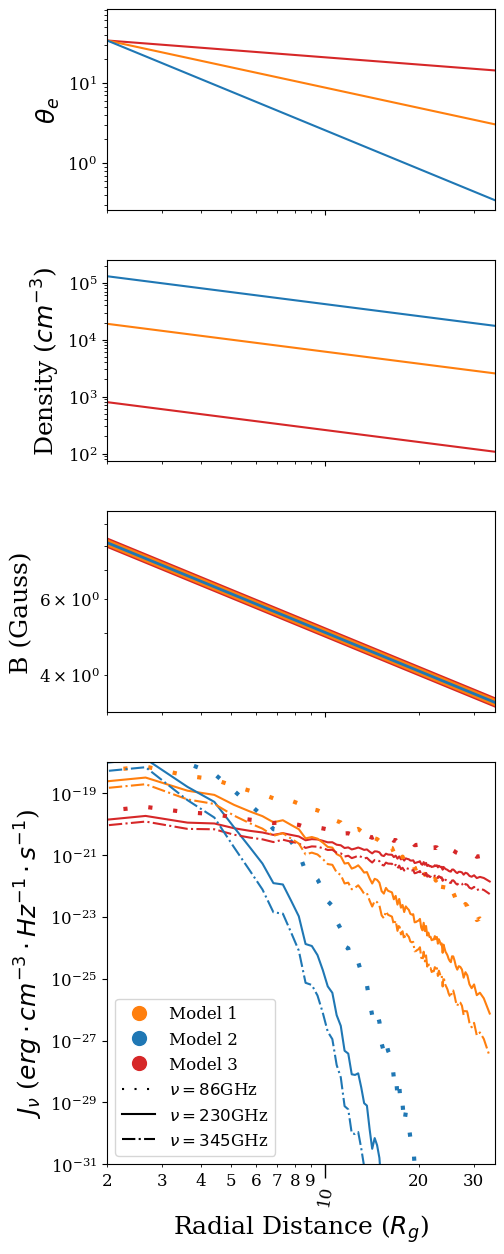

In [50]:
fig = plt.subplots(4,1, sharex='col', figsize=(5,15), height_ratios=[1,1,1,2])
# [r, theta_e.value, n.value, b_field.value, b_nu_fluid.value,
#                                   acoeff_I_fluid.value, tau_curve.value, specific_intensity_thin_packed.value,
#                                  specific_intensity_thick_packed.value], axis=0)
ax = [None, None, None, None]

# Feducial ORange
# 	1.23e4, # n_th0
# 	8.1e9, # t_e0
# 	-.7, # p_dens
# 	-.84 # p_temp

# Steeper Blue
# 	2.9726e+05, # n_th0
# 	-.7, # p_dens
# 	-1.6 # p_temp

# Shallower RED
# 	2.1526e+04, # n_th0
# 	-.7, # p_dens
# 	-.3 # p_temp

i=0
n=3000

# Subplot 1-----------------------------------------
ax[0] = plt.subplot(4,1,1)
ax[0].plot(bp0s["bp_shallowT230"][0,:], bp0s["bp_shallowT230"][1,:], 'tab:red')
ax[0].plot(bp0s["bp_fiducial230"][0,:], bp0s["bp_fiducial230"][1,:], 'tab:orange')
ax[0].plot(bp0s["bp_steeperT230"][0,:], bp0s["bp_steeperT230"][1,:], 'tab:blue')

ax[0].set_ylabel(R'$\theta_e$', fontsize=18)
ax[0].set_yscale('log')

# Subplot 2-----------------------------------------
ax[1] = plt.subplot(4,1,2)
ax[1].plot(bp0s["bp_shallowT230"][0,:], bp0s["bp_shallowT230"][2,:], 'tab:red')
ax[1].plot(bp0s["bp_fiducial230"][0,:], bp0s["bp_fiducial230"][2,:], 'tab:orange')
ax[1].plot(bp0s["bp_steeperT230"][0,:], bp0s["bp_steeperT230"][2,:], 'tab:blue')

ax[1].set_ylabel('Density ({})'.format(R'$cm^{-3}$'), fontsize=18)
ax[1].set_yscale('log')

# Subplot 3-----------------------------------------
ax[2] = plt.subplot(4,1,3)


ax[2].plot(bp0s["bp_shallowT230"][0,:], bp0s["bp_shallowT230"][3,:], 'tab:red', linewidth=7)
ax[2].plot(bp0s["bp_fiducial230"][0,:], bp0s["bp_fiducial230"][3,:], 'tab:orange', linewidth=5)
ax[2].plot(bp0s["bp_steeperT230"][0,:], bp0s["bp_steeperT230"][3,:], 'tab:blue', linewidth=2)

ax[2].set_yscale('log')
ax[2].set_ylabel('B (Gauss)', fontsize=18)

# Subplot 4-----------------------------------------
ax[3] = plt.subplot(4,1,4)


ax[3].plot(bp0s["bp_shallowT230"][0,i::n], bp0s["bp_shallowT230"][7,i::n], 'tab:red', label="Model 3")
ax[3].plot(bp0s["bp_fiducial230"][0,i::n], bp0s["bp_fiducial230"][7,i::n], 'tab:orange',label="Model 1")
ax[3].plot(bp0s["bp_steeperT230"][0,i::n], bp0s["bp_steeperT230"][7,i::n], 'tab:blue', label="Model 2")


ax[3].plot(bp0s["bp_shallowT86"][0,i::n], bp0s["bp_shallowT86"][7,i::n], 'tab:red',linewidth=3, label="Model 3",linestyle=(0, (1, 5)))
ax[3].plot(bp0s["bp_fiducial86"][0,i::n], bp0s["bp_fiducial86"][7,i::n], 'tab:orange',linewidth=3,label="Model 1",linestyle=(0, (1, 5)))
ax[3].plot(bp0s["bp_steeperT86"][0,i::n], bp0s["bp_steeperT86"][7,i::n], 'tab:blue',linewidth=3, label="Model 2",linestyle=(0, (1, 5)))


ax[3].plot(bp0s["bp_shallowT345"][0,i::n], bp0s["bp_shallowT345"][7,i::n], 'tab:red', label="Model 3",linestyle='-.')
ax[3].plot(bp0s["bp_fiducial345"][0,i::n], bp0s["bp_fiducial345"][7,i::n], 'tab:orange',label="Model 1",linestyle='-.')
ax[3].plot(bp0s["bp_steeperT345"][0,i::n], bp0s["bp_steeperT345"][7,i::n], 'tab:blue', label="Model 2",linestyle='-.')



ax[3].set_ylabel(R'$J_\nu$ ($erg \cdot cm^{-3} \cdot Hz^{-1} \cdot s^{-1}$)', fontsize=18)
ax[3].set_yscale('log')
ax[3].set_xscale('log')
ax[3].minorticks_on()
ax[3].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
ax[3].xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.0f'))
ax[3].set_xlabel('Radial Distance ({})'.format(R'$R_g$'), fontsize=18 )
ax[3].set_xlim([2,35])

lines = [
    Line2D([0],[0],marker='o', markerfacecolor='tab:orange', color='w', markersize=12),
    Line2D([0],[0],marker='o', markerfacecolor='tab:blue', color='w', markersize=12),
    Line2D([0],[0],marker='o', markerfacecolor='tab:red', color='w', markersize=12),
    Line2D([0,1],[0,1],linestyle=(0, (1, 5)), color='k'), 
    Line2D([0,1],[0,1],linestyle='-', color='k'), 
    Line2D([0,1],[0,1],linestyle='-.', color='k')
    ]
labels = [
    "Model 1",
    "Model 2",
    "Model 3",
    R'$\nu = 86$GHz',
    R'$\nu = 230$GHz',
    R'$\nu = 345$GHz'
          ]

ax[3].legend(lines,labels)
ax[3].set_ylim([1e-31, 1e-18])
ax[3].tick_params('x', length=10, width=1, which='major', labelrotation=80)

plt.savefig(fig_path + "emission_profiles.png", bbox_inches='tight')






### Final Image Comparisons

In [58]:

args = ' '
cmd1_args = {
    "nu0": '--nu ',
    "mass": '--mass ',
    "scale_height": '--scaleh ',
    "theta_b": '--thetab ',
    "beta": '--beta ',
    "r_ie": '--rie ',
    "rb_0": '--rb0 ',
    "n_th0": '--nth0 ',
    "t_e0": '--te0 ',
    "p_dens": '--pdens ',
    "p_temp": '--ptemp ',
    "nscale": '--nscale ',
}

cmd2_args = {
    "emodelkey": '--emodelkey ',
    "bkey": '--bkey ',
    "nnoisykey": '--nnoisykey ',
    "tnoisykey": '--tnoisykey ',
    "bnoisykey": '--bnoisykey ',
}

brightparams = {
    "nu0": 230e9,  # 0 nu0
    "mass": (MMkg * u.kg).to(u.g).value,  # 1 mass
    "scale_height": .5,  # 2 scale_height
    "theta_b": 50.0 * (np.pi / 180),  # 3 theta_b
    "beta": 1.0,  # 4 beta
    "r_ie": 10.0,  # 5 rie
    "rb_0": 2,  # 7 rb_0
    "n_th0": 1.9e4,  # ,4e5 # 8 n_th0
    "t_e0": 2e11,  # 9 t_e0 1e12
    "p_dens": -.7,  # 10 p_dens
    "p_temp": -.84,  # 11 p_temp
    "nscale": .4  # Scale of Inoisy
}

funckeys = {
    "emodelkey": 0,  # emodelkey Emission Model choice, 0 = thermal ultrarelativistic, 1 = power law
    "bkey": 2,  # bkey
    "nnoisykey": 0,  # nnoisykey Inoisy density. 0 = no noise, 1 = noise
    "tnoisykey": 0,  # tnoisykey Inoisy temperature
    "bnoisykey": 0  # bnoisykey Inoisy magnetic field
}




In [59]:
# brightparams = fpp.bp_steeperT
# funckeys = fpp.fk_fiducial
fpp.bp_fiducial230
for arg in cmd1_args:
    args = args + cmd1_args[arg] + str(brightparams[arg]) + ' '

for arg in cmd2_args:
    args = args + cmd2_args[arg] + str(funckeys[arg]) + ' '

# for i in range(len(brightparams)):
#     args = args + cmd1_args[i] + str(brightparams[i]) + ' '
aartpath = '/home/tej/Desktop/Code_Stuff/Repositories/aart'
subprocess.run(['python3 ' + aartpath + '/radialintensity.py' + args], shell=True)


Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Rays_a_0.94_i_17.h5
Intensity
Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/LensingBands_a_0.94_i_17.h5
Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Rays_a_0.94_i_17.h5
File  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Intensity_a_0.94_i_17_nu_2.30000e+11_mass_1.32497e+43_scaleh_0.5_thetab_0.873_beta_1.00_rie_10.0_rb_2.0_nth0_1.9e+04_te0_2.0e+11_pdens_-0.7_ptemp_-0.84_nscale_0.4_emkey_0_bkey_2_nkey_0_tnkey_0_bnkey_0.h5  created.


CompletedProcess(args=['python3 /home/tej/Desktop/Code_Stuff/Repositories/aart/radialintensity.py --nu 230000000000.0 --mass 1.3249659172847406e+43 --scaleh 0.5 --thetab 0.8726646259971648 --beta 1.0 --rie 10.0 --rb0 2 --nth0 19000.0 --te0 200000000000.0 --pdens -0.7 --ptemp -0.84 --nscale 0.4 --emodelkey 0 --bkey 2 --nnoisykey 0 --tnoisykey 0 --bnoisykey 0 '], returncode=0)

In [60]:

# TODO: modify name
# fnrays='./Results/Intensity_a_{}|i_{}|nu_{}|mass_{}|scaleh_{}|thetab_{}|beta_{}|rie_{}|rb_{}|nth0_{}|te0_{}|pdens_{}|ptemp_{}|nscale_{}|emkey_{}|bkey_{}|nkey_{}|tnke
fnrays = path + 'Intensity_a_{}_i_{}_nu_{}_mass_{}_scaleh_{}_thetab_{}_beta_{}_rie_{}_rb_{}_nth0_{}_te0_{}_pdens_{}_ptemp_{}_nscale_{}_emkey_{}_bkey_{}_nkey_{}_tnkey_{}_bnkey_{}.h5'.format(
    spin_case,
    i_case,
    "{:.5e}".format(brightparams["nu0"]),
    "{:.5e}".format(brightparams["mass"]),
    float(brightparams["scale_height"]),
    "{:.3f}".format(brightparams["theta_b"]),
    "{:.2f}".format(float(brightparams["beta"])),
    "{:.1f}".format(float(brightparams["r_ie"])),
    "{:.1f}".format(float(brightparams["rb_0"])),
    "{:.1e}".format(brightparams["n_th0"]),
    "{:.1e}".format(brightparams["t_e0"]),
    float(brightparams["p_dens"]),
    float(brightparams["p_temp"]),
    "{:.1f}".format(brightparams["nscale"]),
    funckeys["emodelkey"],
    funckeys["bkey"],
    funckeys["nnoisykey"],
    funckeys["tnoisykey"],
    funckeys["bnoisykey"]
)

print("Reading file: ", fnrays)

h5f = h5py.File(fnrays, 'r')

I0_tej = h5f['bghts0'][:]  # This implies I0 is 1 pass
I1_tej = h5f['bghts1'][:]
I2_tej = h5f['bghts2'][:]

Absorbtion_Image_tej = h5f['bghts_full_absorbtion'][:]

h5f.close()


Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Intensity_a_0.94_i_17_nu_2.30000e+11_mass_1.32497e+43_scaleh_0.5_thetab_0.873_beta_1.00_rie_10.0_rb_2.0_nth0_1.9e+04_te0_2.0e+11_pdens_-0.7_ptemp_-0.84_nscale_0.4_emkey_0_bkey_2_nkey_0_tnkey_0_bnkey_0.h5


In [61]:
fnrays = "/home/tej/Desktop/Code_Stuff/Repositories/aart_base/aart/Results/Intensity_a_%s_i_%s.h5" % (spin_case, i_case)

print("Reading file: ", fnrays)

h5f = h5py.File(fnrays, 'r')

I0_base = h5f['bghts0'][:]
I1_base = h5f['bghts1'][:]
I2_base = h5f['bghts2'][:]

h5f.close()


Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_base/aart/Results/Intensity_a_0.94_i_17.h5


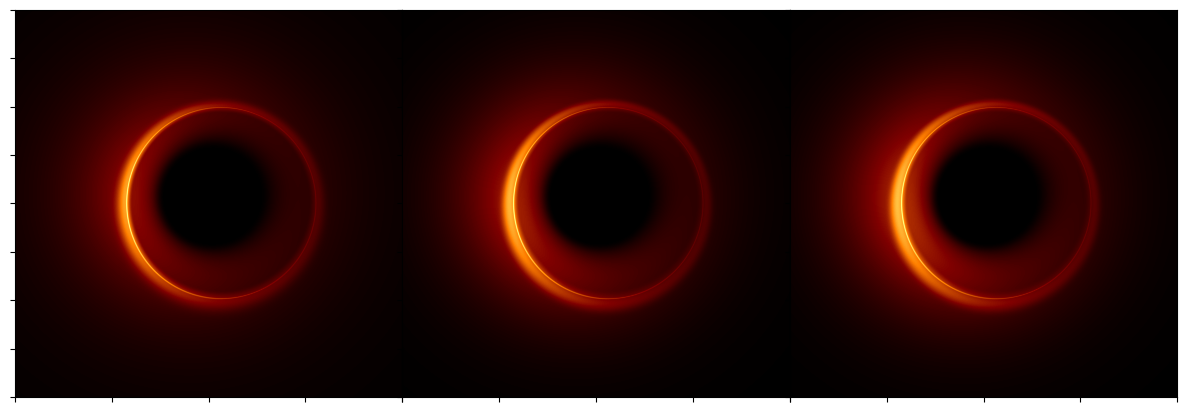

In [63]:
fig, ax = plt.subplots(1,3,figsize=[15, 10])  #, dpi=400
ax[0].remove()
ax[1].remove()
ax[2].remove()

ax = [None, None, None]
# Subplot 1___________________________________________________
ax[0]  = plt.subplot(1,3,1)
ax[0].imshow(I0_base + I1_base + I2_base, vmax=np.max(I0_base + I1_base + I2_base) * 1.2, origin="lower", cmap="afmhot",
          extent=[-lim0, lim0, -lim0, lim0])

ax[0].set_xlim(-10, 10)
ax[0].set_ylim(-10, 10)


ax[0].tick_params('x', which="both", labelbottom=False)
ax[0].tick_params('y', which="both", labelleft=False)

#plt.savefig('BHImage.png',dpi=400,bbox_inches='tight')
# Subplot 2___________________________________________________
ax[1]  = plt.subplot(1,3,2)
ax[1].imshow(I0_tej + I1_tej + I2_tej, vmax=np.max(I0_tej + I1_tej + I2_tej) * 1.2, origin="lower", cmap="afmhot",
          extent=[-lim0, lim0, -lim0, lim0])

ax[1].set_xlim(-10, 10)
ax[1].set_ylim(-10, 10)


ax[1].tick_params('x', which="both", labelbottom=False)
ax[1].tick_params('y', which="both", labelleft=False)

#plt.savefig('BHImage.png',dpi=400,bbox_inches='tight')

# Subplot 3___________________________________________________
ax[2] = plt.subplot(1,3,3)
ax[2].imshow(Absorbtion_Image_tej, vmax=np.max(Absorbtion_Image_tej) * 1.2, origin="lower", cmap="afmhot",
          extent=[-lim0, lim0, -lim0, lim0])

ax[2].set_xlim(-10, 10)
ax[2].set_ylim(-10, 10)


ax[2].tick_params('x', which="both", labelbottom=False)
ax[2].tick_params('y', which="both", labelleft=False)

plt.subplots_adjust(wspace=0)
plt.savefig(fig_path + "aart_compare.jpeg", bbox_inches='tight', dpi=400)
plt.show()




### Noisy Images

In [29]:

args = ' '
cmd1_args = {
    "nu0": '--nu ',
    "mass": '--mass ',
    "scale_height": '--scaleh ',
    "theta_b": '--thetab ',
    "beta": '--beta ',
    "r_ie": '--rie ',
    "rb_0": '--rb0 ',
    "n_th0": '--nth0 ',
    "t_e0": '--te0 ',
    "p_dens": '--pdens ',
    "p_temp": '--ptemp ',
    "nscale": '--nscale ',
}

cmd2_args = {
    "emodelkey": '--emodelkey ',
    "bkey": '--bkey ',
    "nnoisykey": '--nnoisykey ',
    "tnoisykey": '--tnoisykey ',
    "bnoisykey": '--bnoisykey ',
}

brightparams = {
    "nu0": 60e9,  # 0 nu0
    "mass": (MMkg * u.kg).to(u.g).value,  # 1 mass
    "scale_height": .5,  # 2 scale_height
    "theta_b": 50.0 * (np.pi / 180),  # 3 theta_b
    "beta": 1.0,  # 4 beta
    "r_ie": 10.0,  # 5 rie
    "rb_0": 2,  # 7 rb_0
    "n_th0": 1.9e4,  # ,4e5 # 8 n_th0
    "t_e0": 2e11,  # 9 t_e0 1e12
    "p_dens": -.7,  # 10 p_dens
    "p_temp": -.84,  # 11 p_temp
    "nscale": .3  # Scale of Inoisy
}

funckeys = {
    "emodelkey": 0,  # emodelkey Emission Model choice, 0 = thermal ultrarelativistic, 1 = power law
    "bkey": 2,  # bkey
    "nnoisykey": 1,  # nnoisykey Inoisy density. 0 = no noise, 1 = noise
    "tnoisykey": 1,  # tnoisykey Inoisy temperature
    "bnoisykey": 1  # bnoisykey Inoisy magnetic field
}



In [31]:

for arg in cmd1_args:
    args = args + cmd1_args[arg] + str(brightparams[arg]) + ' '

for arg in cmd2_args:
    args = args + cmd2_args[arg] + str(funckeys[arg]) + ' '

# for i in range(len(brightparams)):
#     args = args + cmd1_args[i] + str(brightparams[i]) + ' '
aartpath = '/home/tej/Desktop/Code_Stuff/Repositories/aart'
subprocess.run(['python3 ' + aartpath + '/radialintensity.py' + args], shell=True)



Thanks for using AART
Copyright (C) 2022, A. Cardenas-Avendano, H. Zhu & A. Lupsasca

Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Rays_a_0.94_i_17.h5
Intensity
Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/LensingBands_a_0.94_i_17.h5
Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Rays_a_0.94_i_17.h5
File  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Intensity_a_0.94_i_17_nu_6.00000e+10_mass_1.32497e+43_scaleh_0.5_thetab_0.873_beta_1.00_rie_10.0_rb_2.0_nth0_1.9e+04_te0_2.0e+11_pdens_-0.7_ptemp_-0.84_nscale_0.3_emkey_0_bkey_2_nkey_1_tnkey_1_bnkey_1.h5  created.


CompletedProcess(args=['python3 /home/tej/Desktop/Code_Stuff/Repositories/aart/radialintensity.py --nu 60000000000.0 --mass 1.3249659172847406e+43 --scaleh 0.5 --thetab 0.8726646259971648 --beta 1.0 --rie 10.0 --rb0 2 --nth0 19000.0 --te0 200000000000.0 --pdens -0.7 --ptemp -0.84 --nscale 0.3 --emodelkey 0 --bkey 2 --nnoisykey 1 --tnoisykey 1 --bnoisykey 1 --nu 60000000000.0 --mass 1.3249659172847406e+43 --scaleh 0.5 --thetab 0.8726646259971648 --beta 1.0 --rie 10.0 --rb0 2 --nth0 19000.0 --te0 200000000000.0 --pdens -0.7 --ptemp -0.84 --nscale 0.3 --emodelkey 0 --bkey 2 --nnoisykey 1 --tnoisykey 1 --bnoisykey 1 '], returncode=0)

In [32]:
# TODO: modify name
# fnrays='./Results/Intensity_a_{}|i_{}|nu_{}|mass_{}|scaleh_{}|thetab_{}|beta_{}|rie_{}|rb_{}|nth0_{}|te0_{}|pdens_{}|ptemp_{}|nscale_{}|emkey_{}|bkey_{}|nkey_{}|tnke
fnrays = path + 'Intensity_a_{}_i_{}_nu_{}_mass_{}_scaleh_{}_thetab_{}_beta_{}_rie_{}_rb_{}_nth0_{}_te0_{}_pdens_{}_ptemp_{}_nscale_{}_emkey_{}_bkey_{}_nkey_{}_tnkey_{}_bnkey_{}.h5'.format(
    spin_case,
    i_case,
    "{:.5e}".format(brightparams["nu0"]),
    "{:.5e}".format(brightparams["mass"]),
    float(brightparams["scale_height"]),
    "{:.3f}".format(brightparams["theta_b"]),
    "{:.2f}".format(float(brightparams["beta"])),
    "{:.1f}".format(float(brightparams["r_ie"])),
    "{:.1f}".format(float(brightparams["rb_0"])),
    "{:.1e}".format(brightparams["n_th0"]),
    "{:.1e}".format(brightparams["t_e0"]),
    float(brightparams["p_dens"]),
    float(brightparams["p_temp"]),
    "{:.1f}".format(brightparams["nscale"]),
    funckeys["emodelkey"],
    funckeys["bkey"],
    funckeys["nnoisykey"],
    funckeys["tnoisykey"],
    funckeys["bnoisykey"]
)

print("Reading file: ", fnrays)

h5f = h5py.File(fnrays, 'r')

I0_tej = h5f['bghts0'][:]  # This implies I0 is 1 pass
I1_tej = h5f['bghts1'][:]
I2_tej = h5f['bghts2'][:]

Absorbtion_Image_tej = h5f['bghts_full_absorbtion'][:]

h5f.close()

Reading file:  /home/tej/Desktop/Code_Stuff/Repositories/aart_results/path_results/Intensity_a_0.94_i_17_nu_6.00000e+10_mass_1.32497e+43_scaleh_0.5_thetab_0.873_beta_1.00_rie_10.0_rb_2.0_nth0_1.9e+04_te0_2.0e+11_pdens_-0.7_ptemp_-0.84_nscale_0.3_emkey_0_bkey_2_nkey_1_tnkey_1_bnkey_1.h5


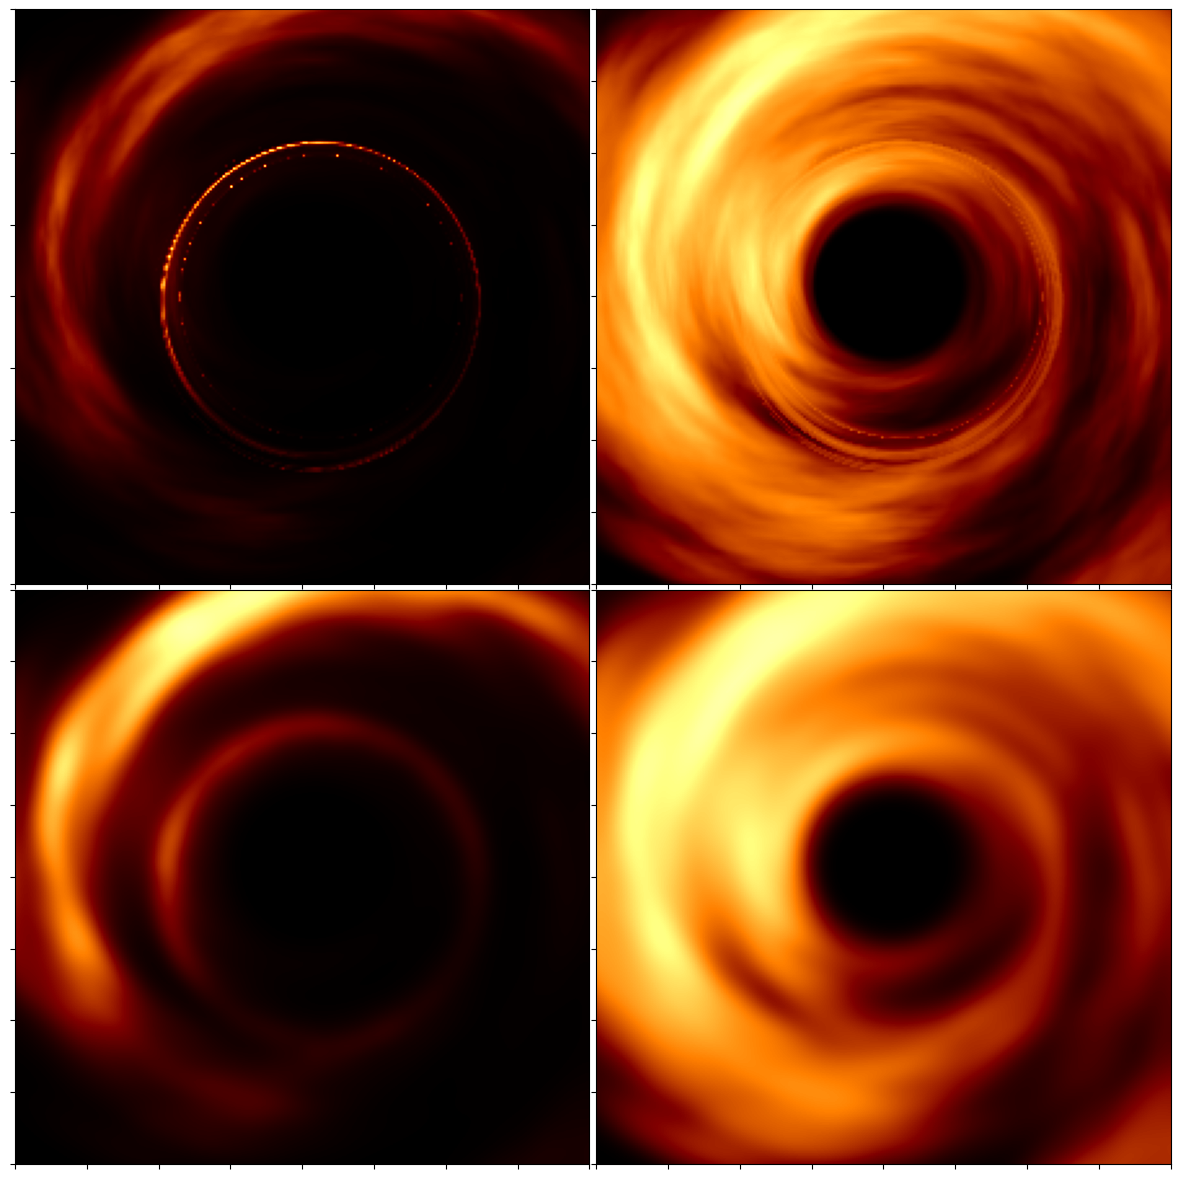

In [33]:
fig, ax = plt.subplots(2,2,figsize=[15, 15])  #, dpi=400


sigma_val = 4

ax = [None, None]
# Subplot 1___________________________________________________
ax[0]  = plt.subplot(2,2,1)
ax[0].imshow(I0_tej + I1_tej + I2_tej, vmax=np.max(I0_tej + I1_tej + I2_tej) * 1.2, origin="lower", cmap="afmhot",
          extent=[-lim0, lim0, -lim0, lim0])

ax[0].set_xlim(-10, 10)
ax[0].set_ylim(-10, 10)


ax[0].tick_params('x', which="both", labelbottom=False)
ax[0].tick_params('y', which="both", labelleft=False)

#plt.savefig('BHImage.png',dpi=400,bbox_inches='tight')
# Subplot 2___________________________________________________
ax[1]  = plt.subplot(2,2,2)
ax[1].imshow(Absorbtion_Image_tej, vmax=np.max(Absorbtion_Image_tej) * 1.2, origin="lower", cmap="afmhot",
          extent=[-lim0, lim0, -lim0, lim0])

ax[1].set_xlim(-10, 10)
ax[1].set_ylim(-10, 10)


ax[1].tick_params('x', which="both", labelbottom=False)
ax[1].tick_params('y', which="both", labelleft=False)



# Subplot 3___________________________________________________
blurTotalThin = scipy.ndimage.gaussian_filter(I0_tej + I1_tej + I2_tej, sigma=sigma_val)
ax[1]  = plt.subplot(2,2,3)
ax[1].imshow(blurTotalThin, vmax=np.max(blurTotalThin) * 1.2, origin="lower", cmap="afmhot",
          extent=[-lim0, lim0, -lim0, lim0])

ax[1].set_xlim(-10, 10)
ax[1].set_ylim(-10, 10)


ax[1].tick_params('x', which="both", labelbottom=False)
ax[1].tick_params('y', which="both", labelleft=False)

# Subplot 3___________________________________________________
blurTotalThick = scipy.ndimage.gaussian_filter(Absorbtion_Image_tej, sigma=sigma_val)

ax[1]  = plt.subplot(2,2,4)
ax[1].imshow(blurTotalThick, vmax=np.max(blurTotalThick) * 1.2, origin="lower", cmap="afmhot",
          extent=[-lim0, lim0, -lim0, lim0])

ax[1].set_xlim(-10, 10)
ax[1].set_ylim(-10, 10)


ax[1].tick_params('x', which="both", labelbottom=False)
ax[1].tick_params('y', which="both", labelleft=False)


plt.subplots_adjust(wspace=0.0)
plt.subplots_adjust(hspace=0.01)


plt.savefig(fig_path + "Inoisy.png",dpi=400,bbox_inches='tight')


### Compare Radii

In [9]:
Model1_fid_path = "/home/tej/Desktop/Code_Stuff/Repositories/aart_results/Movie/low_rez/video/For_Radii/Fiducial/data_sets/"
Model2_steep_path = "/home/tej/Desktop/Code_Stuff/Repositories/aart_results/Movie/low_rez/video/For_Radii/Steeper/data_sets/"
Model3_Shallow_path = "/home/tej/Desktop/Code_Stuff/Repositories/aart_results/Movie/low_rez/video/For_Radii/Shallow/data_sets/"

r0_string = "mean_radii_I0_Thin.npy"
r1_string = "mean_radii_I1_Thin.npy"
r2_string = "mean_radii_I2_Thin.npy"

r0_thick_string = "mean_radii_I0_Thick.npy"
r1_thick_string = "mean_radii_I1_Thick.npy"
r2_thick_string = "mean_radii_I2_Thick.npy"


r_outer = np.load('./Movie_Maker/r_outer_spin_{}_inc_{}.npy'.format(spin_case,  i_case))
x_variable = np.load(Model1_fid_path + "x_variable.npy")

Model1 = np.load(Model1_fid_path + "mean_radii_Thin.npy")

Model2 = np.load(Model2_steep_path  + "mean_radii_Thin.npy")

Model3 = np.load(Model3_Shallow_path + "mean_radii_Thin.npy")

Model1_thick = np.load(Model1_fid_path + "mean_radii_Thick.npy")

Model2_thick = np.load(Model2_steep_path  + "mean_radii_Thick.npy")

Model3_thick = np.load(Model3_Shallow_path + "mean_radii_Thick.npy")



In [103]:
# Start_1.00e+10_Stop_7.00e+11_Step_1.50e+10
start = 1.00e+10
step = 1.50e+10

conv_1 = start + step * ilp.ring_convergance(Model1_thick[:, 2], Model1_thick[:, 3], 5)
conv_1 = conv_1 / 1e9
# 
# conv_2 = start + step * ilp.ring_convergance(Model2_thick[:, 2], Model2_thick[:, 3], 5)
# conv_2 = conv_2 / 1e9
# 
# conv_3 = start + step * ilp.ring_convergance(Model3_thick[:, 2], Model3_thick[:, 3], 5)
# conv_3 = conv_3 / 1e9

In [40]:
print(conv_1)
# print(conv_2)
# print(conv_3)

70.0
10.0
10.0


/tmp/ipykernel_59872/2523046553.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[0] = plt.subplot(3,1,1)
/tmp/ipykernel_59872/2523046553.py:53: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[1] = plt.subplot(2,3,4)
/tmp/ipykernel_59872/2523046553.py:69: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[2] = plt.subplot(2,3,5, sharey=ax[1])
/tmp/ipykernel_59872/2523046553.py:84: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax[3] = plt.subplot(2,3,6, sharey=ax[1])


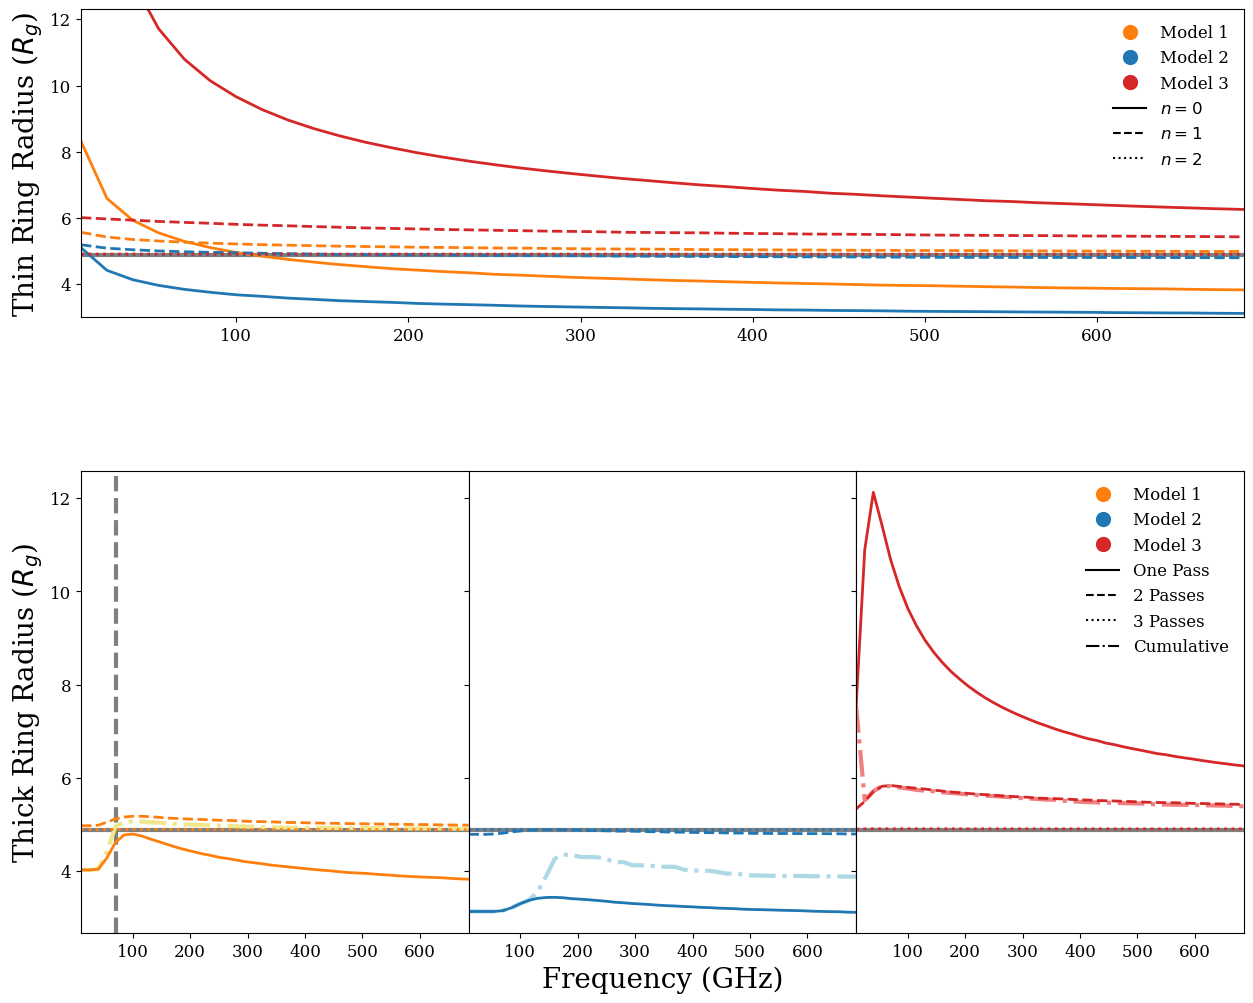

In [110]:
from matplotlib.lines import Line2D

shadowlines = 3
ringlines = 2

fig = plt.subplots(3,3,figsize=[15, 12])
ax = [None, None, None, None]
ax[0] = plt.subplot(3,1,1)

xaxis = x_variable / 1e9

ax[0].hlines(r_outer, xaxis[0], np.max(xaxis), colors='tab:grey', linewidth=shadowlines)

ax[0].plot(xaxis, Model1[:,0], color='tab:orange', linestyle='-', linewidth=ringlines)
ax[0].plot(xaxis, Model1[:,1], color='tab:orange', linestyle='--', linewidth=ringlines)
ax[0].plot(xaxis, Model1[:,2], color='tab:orange', linestyle=':', linewidth=ringlines)

ax[0].plot(xaxis, Model2[:,0], color='tab:blue', linestyle='-', linewidth=ringlines)
ax[0].plot(xaxis, Model2[:,1], color='tab:blue', linestyle='--', linewidth=ringlines)
ax[0].plot(xaxis, Model2[:,2], color='tab:blue', linestyle=':', linewidth=ringlines)

ax[0].plot(xaxis, Model3[:,0], color='tab:red', linestyle='-', linewidth=ringlines)
ax[0].plot(xaxis, Model3[:,1], color='tab:red', linestyle='--', linewidth=ringlines)
ax[0].plot(xaxis, Model3[:,2], color='tab:red', linestyle=':', linewidth=ringlines)

ax[0].set_ylabel(R'Thin Ring Radius ($R_g$)', fontsize=20)
ax[0].set_xlim(xaxis[0], np.max(xaxis))
ax[0].set_ylim(3, 12.3)


lines = [
    Line2D([0],[0],marker='o', markerfacecolor='tab:orange', color='w', markersize=12),
    Line2D([0],[0],marker='o', markerfacecolor='tab:blue', color='w', markersize=12),
    Line2D([0],[0],marker='o', markerfacecolor='tab:red', color='w', markersize=12),
    Line2D([0,1],[0,1],linestyle='-', color='k'), 
    Line2D([0,1],[0,1],linestyle='--', color='k'), 
    Line2D([0,1],[0,1],linestyle=':', color='k')
    ]
labels = [
    "Model 1",
    "Model 2",
    "Model 3",
    R'$n = 0$',
    R'$n = 1$',
    R'$n = 2$'
          ]

ax[0].legend(lines,labels, frameon=False)

#  subplots 2_________________________________________________________________
size_multiplier = 1.5

ax[1] = plt.subplot(2,3,4)

xaxis = x_variable / 1e9

ax[1].hlines(r_outer, xaxis[0], np.max(xaxis), colors='tab:grey', linewidth=shadowlines)
ax[1].axvline(conv_1, color='grey', linestyle="--", linewidth=3)

ax[1].plot(xaxis, Model1_thick[:,3], color='khaki', linestyle='-.', linewidth=ringlines * size_multiplier)
ax[1].plot(xaxis, Model1_thick[:,0], color='tab:orange', linestyle='-', linewidth=ringlines)
ax[1].plot(xaxis, Model1_thick[:,1], color='tab:orange', linestyle='--', linewidth=ringlines)
ax[1].plot(xaxis, Model1_thick[:,2], color='tab:orange', linestyle=':', linewidth=ringlines)
ax[1].set_ylabel(R'Thick Ring Radius ($R_g$)', fontsize=20)
ax[1].set_xlim(xaxis[0], np.max(xaxis))


#  subplots 3_________________________________________________________________
ax[2] = plt.subplot(2,3,5, sharey=ax[1])


ax[2].hlines(r_outer, xaxis[0], np.max(xaxis), colors='tab:grey', linewidth=shadowlines)


ax[2].plot(xaxis, Model2_thick[:,3], color='lightblue', linestyle='-.', linewidth=ringlines * size_multiplier)
ax[2].plot(xaxis, Model2_thick[:,0], color='tab:blue', linestyle='-', linewidth=ringlines)
ax[2].plot(xaxis, Model2_thick[:,1], color='tab:blue', linestyle='--', linewidth=ringlines)
ax[2].plot(xaxis, Model2_thick[:,2], color='tab:blue', linestyle=':', linewidth=ringlines)
ax[2].set_xlabel(R'Frequency (GHz)', fontsize=20)
ax[2].tick_params('y', which="major", labelleft=False)
ax[2].set_xlim(xaxis[0], np.max(xaxis))

#  subplots 4_________________________________________________________________
ax[3] = plt.subplot(2,3,6, sharey=ax[1])

ax[3].hlines(r_outer, xaxis[0], np.max(xaxis), colors='tab:grey', linewidth=shadowlines)


ax[3].plot(xaxis, Model3_thick[:,3], color='lightcoral', linestyle='-.', linewidth=ringlines * size_multiplier)
ax[3].plot(xaxis, Model3_thick[:,0], color='tab:red', linestyle='-', linewidth=ringlines)
ax[3].plot(xaxis, Model3_thick[:,1], color='tab:red', linestyle='--', linewidth=ringlines)
ax[3].plot(xaxis, Model3_thick[:,2], color='tab:red', linestyle=':', linewidth=ringlines)
ax[3].tick_params('y', which="major", labelleft=False)

lines = [
    Line2D([0],[0],marker='o', markerfacecolor='tab:orange', color='w', markersize=12),
    Line2D([0],[0],marker='o', markerfacecolor='tab:blue', color='w', markersize=12),
    Line2D([0],[0],marker='o', markerfacecolor='tab:red', color='w', markersize=12),
    Line2D([0,1],[0,1],linestyle='-', color='k'), 
    Line2D([0,1],[0,1],linestyle='--', color='k'), 
    Line2D([0,1],[0,1],linestyle=':', color='k'),
    Line2D([0,1],[0,1],linestyle='-.', color='k')
    ]
labels = [
    "Model 1",
    "Model 2",
    "Model 3",
    R'One Pass',
    R'2 Passes',
    R'3 Passes',
    R'Cumulative'
          ]

ax[3].set_xlim(xaxis[0], np.max(xaxis))
ax[3].legend(lines,labels, frameon=False)
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig(fig_path + "RadiiModels.png",dpi=400,bbox_inches='tight')